
# `4. Regression`

## 4.1 Import Libraries

In [0]:
from pyspark.sql import Row
from pyspark.sql.functions import (
    col, when, floor, hour, minute, second,
    count, mean, stddev, min as spark_min, max as spark_max)
from pyspark.sql.types import (
    StructType, StructField, StringType, FloatType,
    IntegerType, LongType, DoubleType)

# PySpark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, StringIndexerModel, OneHotEncoder,
    VectorAssembler, StandardScaler, SQLTransformer)
from pyspark.ml.functions import vector_to_array
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

# Utility libraries
from collections import defaultdict
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas (used for plotting or table formatting)
import pandas as pd

## 4.2 Import Dfs

In [0]:
clustering_map_train = spark.read.option("header", "true").csv("/FileStore/tables/mapping_train_df.csv")
clustering_map_val = spark.read.option("header", "true").csv("/FileStore/tables/mapping_val_df.csv")
clustering_map_test = spark.read.option("header", "true").csv("/FileStore/tables/mapping_test_df.csv")

In [0]:
train_df = spark.read.format("delta").load("/dbfs/FileStore/tables/train_df")
val_df = spark.read.format("delta").load("/dbfs/FileStore/tables/val_df")
test_df = spark.read.format("delta").load("/dbfs/FileStore/tables/test_df")

In [0]:
display(clustering_map_train.limit(10))

index,cluster
1,4
2,3
3,4
4,4
5,2
6,4
7,2
8,1
9,1
10,1


In [0]:
display(train_df.limit(10))


ROUTE,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIRLINE,FLIGHT_NUMBER,index,YEAR,MONTH,DAY,DAY_OF_WEEK,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SEASON,SCHEDULED_DEPARTURE_PERIOD,IS_WEEKEND,DELAYED_DEPARTURE_FLAG,TOTAL_KNOWN_DELAY,SCHEDULED_DEPARTURE_min,SCHEDULED_ARRIVAL_min,DEPARTURE_TIME_min,WHEELS_OFF_min,ARRIVAL_TIME_min,SEASON_vec,SCHEDULED_DEPARTURE_PERIOD_vec,FLIGHT_NUMBER_freq,TAIL_NUMBER_freq,AIRLINE_freq,ORIGIN_AIRPORT_freq,DESTINATION_AIRPORT_freq,ROUTE_freq
DCA_BOS,BOS,DCA,AA,2142,2602,2015,12,2,3,-9,62,83,399.0,44,44,0,0,0,0,Winter,Midday,0,0,44,750,833,741,803,877,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,1.33E-4,0.122488,0.012465,0.02114,0.001174
DCA_BOS,BOS,DCA,US,2142,3092,2015,3,3,2,-1,44,85,399.0,26,26,0,0,0,0,Spring,Midday,0,0,26,750,835,749,793,861,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,1.33E-4,0.03179,0.012465,0.02114,0.001174
DCA_BOS,BOS,DCA,US,2122,12648,2015,2,11,3,-1,75,89,399.0,51,51,0,0,0,0,Winter,Afternoon,0,0,51,990,1079,989,1064,1130,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",1.87E-4,3.47E-4,0.03179,0.012465,0.02114,0.001174
DCA_TPA,TPA,DCA,AA,1959,34024,2015,7,28,2,31,29,141,814.0,29,0,0,29,0,0,Summer,Evening,0,1,29,1165,1306,1196,1225,1335,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",1.07E-4,8.0E-5,0.122488,0.012465,0.011744,4.54E-4
DCA_BOS,BOS,DCA,AA,2142,36325,2015,9,30,3,14,35,86,399.0,38,24,0,14,0,0,Autumn,Midday,0,0,38,750,836,764,799,874,"Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,1.33E-4,0.122488,0.012465,0.02114,0.001174
SAV_LGA,LGA,SAV,EV,4900,13228,2015,7,11,6,57,12,129,722.0,41,0,0,11,30,0,Summer,Midday,1,1,41,760,889,817,829,930,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",1.33E-4,5.61E-4,0.100921,0.001655,0.025117,1.07E-4
IAH_TPA,TPA,IAH,UA,1238,1367,2015,1,2,5,25,16,125,787.0,18,0,0,0,18,0,Winter,Afternoon,0,1,18,937,1122,962,978,1140,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",3.2E-4,2.67E-4,0.097264,0.031122,0.011744,5.34E-4
IAH_SHV,SHV,IAH,OO,5518,3799,2015,9,3,4,-5,73,61,192.0,47,47,0,0,0,0,Autumn,Early Morning,0,0,47,445,506,440,513,553,"Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",1.33E-4,3.74E-4,0.10407,0.031122,0.001174,2.67E-4
IAH_BHM,BHM,IAH,OO,5156,10464,2015,5,9,6,32,16,106,562.0,22,0,0,0,22,0,Spring,Afternoon,1,1,22,935,1041,967,983,1063,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",2.4E-4,3.47E-4,0.10407,0.031122,0.002776,3.2E-4
IAH_SAT,SAT,IAH,UA,1591,13811,2015,1,12,1,6,31,65,191.0,16,10,0,6,0,0,Winter,Midday,0,0,16,820,885,826,857,901,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,2.67E-4,0.097264,0.031122,0.006833,5.87E-4


### 4.2.1 Merge clustering_map with the train_df

In [0]:
join_key = "index"

# Merge clustering map with the train_df 
train_df_merged = train_df.join(clustering_map_train, on=join_key, how="left")
val_df_merged = val_df.join(clustering_map_val , on = join_key, how ="left")
test_df_merged = test_df.join(clustering_map_test, on = join_key , how = "left")


In [0]:
display(train_df_merged.limit(10))

index,ROUTE,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIRLINE,FLIGHT_NUMBER,YEAR,MONTH,DAY,DAY_OF_WEEK,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SEASON,SCHEDULED_DEPARTURE_PERIOD,IS_WEEKEND,DELAYED_DEPARTURE_FLAG,TOTAL_KNOWN_DELAY,SCHEDULED_DEPARTURE_min,SCHEDULED_ARRIVAL_min,DEPARTURE_TIME_min,WHEELS_OFF_min,ARRIVAL_TIME_min,SEASON_vec,SCHEDULED_DEPARTURE_PERIOD_vec,FLIGHT_NUMBER_freq,TAIL_NUMBER_freq,AIRLINE_freq,ORIGIN_AIRPORT_freq,DESTINATION_AIRPORT_freq,ROUTE_freq,cluster
2602,DCA_BOS,BOS,DCA,AA,2142,2015,12,2,3,-9,62,83,399.0,44,44,0,0,0,0,Winter,Midday,0,0,44,750,833,741,803,877,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,1.33E-4,0.122488,0.012465,0.02114,0.001174,2
3092,DCA_BOS,BOS,DCA,US,2142,2015,3,3,2,-1,44,85,399.0,26,26,0,0,0,0,Spring,Midday,0,0,26,750,835,749,793,861,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,1.33E-4,0.03179,0.012465,0.02114,0.001174,2
12648,DCA_BOS,BOS,DCA,US,2122,2015,2,11,3,-1,75,89,399.0,51,51,0,0,0,0,Winter,Afternoon,0,0,51,990,1079,989,1064,1130,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",1.87E-4,3.47E-4,0.03179,0.012465,0.02114,0.001174,2
34024,DCA_TPA,TPA,DCA,AA,1959,2015,7,28,2,31,29,141,814.0,29,0,0,29,0,0,Summer,Evening,0,1,29,1165,1306,1196,1225,1335,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",1.07E-4,8.0E-5,0.122488,0.012465,0.011744,4.54E-4,2
36325,DCA_BOS,BOS,DCA,AA,2142,2015,9,30,3,14,35,86,399.0,38,24,0,14,0,0,Autumn,Midday,0,0,38,750,836,764,799,874,"Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,1.33E-4,0.122488,0.012465,0.02114,0.001174,2
13228,SAV_LGA,LGA,SAV,EV,4900,2015,7,11,6,57,12,129,722.0,41,0,0,11,30,0,Summer,Midday,1,1,41,760,889,817,829,930,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",1.33E-4,5.61E-4,0.100921,0.001655,0.025117,1.07E-4,5
1367,IAH_TPA,TPA,IAH,UA,1238,2015,1,2,5,25,16,125,787.0,18,0,0,0,18,0,Winter,Afternoon,0,1,18,937,1122,962,978,1140,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",3.2E-4,2.67E-4,0.097264,0.031122,0.011744,5.34E-4,5
3799,IAH_SHV,SHV,IAH,OO,5518,2015,9,3,4,-5,73,61,192.0,47,47,0,0,0,0,Autumn,Early Morning,0,0,47,445,506,440,513,553,"Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",1.33E-4,3.74E-4,0.10407,0.031122,0.001174,2.67E-4,0
10464,IAH_BHM,BHM,IAH,OO,5156,2015,5,9,6,32,16,106,562.0,22,0,0,0,22,0,Spring,Afternoon,1,1,22,935,1041,967,983,1063,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",2.4E-4,3.47E-4,0.10407,0.031122,0.002776,3.2E-4,3
13811,IAH_SAT,SAT,IAH,UA,1591,2015,1,12,1,6,31,65,191.0,16,10,0,6,0,0,Winter,Midday,0,0,16,820,885,826,857,901,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",2.67E-4,2.67E-4,0.097264,0.031122,0.006833,5.87E-4,3


## 4.3 Drop columns

In [0]:
# List all columns and their data types
for field in train_df_merged.schema.fields:
    print(f"{field.name}: {field.dataType}")

index: IntegerType()
ROUTE: StringType()
DESTINATION_AIRPORT: StringType()
ORIGIN_AIRPORT: StringType()
AIRLINE: StringType()
FLIGHT_NUMBER: IntegerType()
YEAR: IntegerType()
MONTH: IntegerType()
DAY: IntegerType()
DAY_OF_WEEK: IntegerType()
DEPARTURE_DELAY: IntegerType()
TAXI_OUT: IntegerType()
SCHEDULED_TIME: IntegerType()
DISTANCE: DoubleType()
ARRIVAL_DELAY: IntegerType()
AIR_SYSTEM_DELAY: IntegerType()
SECURITY_DELAY: IntegerType()
AIRLINE_DELAY: IntegerType()
LATE_AIRCRAFT_DELAY: IntegerType()
WEATHER_DELAY: IntegerType()
SEASON: StringType()
SCHEDULED_DEPARTURE_PERIOD: StringType()
IS_WEEKEND: IntegerType()
DELAYED_DEPARTURE_FLAG: IntegerType()
TOTAL_KNOWN_DELAY: IntegerType()
SCHEDULED_DEPARTURE_min: LongType()
SCHEDULED_ARRIVAL_min: LongType()
DEPARTURE_TIME_min: LongType()
WHEELS_OFF_min: LongType()
ARRIVAL_TIME_min: LongType()
SEASON_vec: VectorUDT()
SCHEDULED_DEPARTURE_PERIOD_vec: VectorUDT()
FLIGHT_NUMBER_freq: DoubleType()
TAIL_NUMBER_freq: DoubleType()
AIRLINE_freq: Doub

In [0]:
# Define the target
target_col = ["ARRIVAL_DELAY"]

In [0]:
train_df_merged.columns

Out[88]: ['index',
 'ROUTE',
 'DESTINATION_AIRPORT',
 'ORIGIN_AIRPORT',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'SCHEDULED_TIME',
 'DISTANCE',
 'ARRIVAL_DELAY',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY',
 'SEASON',
 'SCHEDULED_DEPARTURE_PERIOD',
 'IS_WEEKEND',
 'DELAYED_DEPARTURE_FLAG',
 'TOTAL_KNOWN_DELAY',
 'SCHEDULED_DEPARTURE_min',
 'SCHEDULED_ARRIVAL_min',
 'DEPARTURE_TIME_min',
 'WHEELS_OFF_min',
 'ARRIVAL_TIME_min',
 'SEASON_vec',
 'SCHEDULED_DEPARTURE_PERIOD_vec',
 'FLIGHT_NUMBER_freq',
 'TAIL_NUMBER_freq',
 'AIRLINE_freq',
 'ORIGIN_AIRPORT_freq',
 'DESTINATION_AIRPORT_freq',
 'ROUTE_freq',
 'cluster']

In [0]:
freq_encoded_cols = ['FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq']
binary_encoded_cols = ['SEASON_vec', 'SCHEDULED_DEPARTURE_PERIOD_vec']
categorical_cols = ['ROUTE', 'DESTINATION_AIRPORT', 'ORIGIN_AIRPORT', 'AIRLINE', 'SEASON', 'SCHEDULED_DEPARTURE_PERIOD', 'IS_WEEKEND', 'DELAYED_DEPARTURE_FLAG', 'FLIGHT_NUMBER']
numerical_cols = ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME_min', 'WHEELS_OFF_min']
temporal_cols = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK']

In [0]:
# Drop the categorical columns that are already encoded
categoricals_to_drop = ['SEASON', 'SCHEDULED_DEPARTURE_PERIOD', 'FLIGHT_NUMBER', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE']

categoricals_to_keep = list(set(categorical_cols) - set(categoricals_to_drop))

In [0]:
final_columns = (['cluster', 'index'] + categoricals_to_keep + binary_encoded_cols + numerical_cols + freq_encoded_cols + target_col)
train_df_cleaned = train_df_merged[final_columns]
val_df_cleaned = val_df_merged[final_columns]
test_df_cleaned = test_df_merged[final_columns]

In [0]:
print("Final columns:")
print(train_df_cleaned.columns)

Final columns:
['cluster', 'index', 'DELAYED_DEPARTURE_FLAG', 'IS_WEEKEND', 'SEASON_vec', 'SCHEDULED_DEPARTURE_PERIOD_vec', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_DEPARTURE_min', 'SCHEDULED_ARRIVAL_min', 'DEPARTURE_TIME_min', 'WHEELS_OFF_min', 'FLIGHT_NUMBER_freq', 'TAIL_NUMBER_freq', 'AIRLINE_freq', 'ORIGIN_AIRPORT_freq', 'DESTINATION_AIRPORT_freq', 'ROUTE_freq', 'ARRIVAL_DELAY']


## 4.4 Scaling

In [0]:
# categorical_to_keep are flags that have value 0 or 1 and binary encoded range from 0 to 1 too
# we have to scale numerical + freq_encoded
features_to_scale = (numerical_cols + freq_encoded_cols)


In [0]:
# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=features_to_scale,
    outputCol="assembled_features"
)

assembled_train_df = assembler.transform(train_df_cleaned)
assembled_val_df = assembler.transform(val_df_cleaned)
assembled_test_df = assembler.transform(test_df_cleaned)


In [0]:
# StandardScaler
scaler = StandardScaler(
    inputCol="assembled_features",
    outputCol="scaled_features",
    withMean=True,   
    withStd=True     
)

scaler_model = scaler.fit(assembled_train_df)

scaled_train_df = scaler_model.transform(assembled_train_df)
scaled_val_df = scaler_model.transform(assembled_val_df)
scaled_test_df = scaler_model.transform(assembled_test_df)

In [0]:
display(scaled_train_df.limit(10))

cluster,index,DELAYED_DEPARTURE_FLAG,IS_WEEKEND,SEASON_vec,SCHEDULED_DEPARTURE_PERIOD_vec,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,SCHEDULED_DEPARTURE_min,SCHEDULED_ARRIVAL_min,DEPARTURE_TIME_min,WHEELS_OFF_min,FLIGHT_NUMBER_freq,TAIL_NUMBER_freq,AIRLINE_freq,ORIGIN_AIRPORT_freq,DESTINATION_AIRPORT_freq,ROUTE_freq,ARRIVAL_DELAY,assembled_features,scaled_features
3,4295,1,1,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0))",92,59,61,192.0,522,583,614,673,1.87E-4,4.27E-4,0.10407,0.029521,0.001975,2.4E-4,131,"Map(vectorType -> dense, length -> 14, values -> List(92.0, 59.0, 61.0, 192.0, 522.0, 583.0, 614.0, 673.0, 1.87E-4, 4.27E-4, 0.10407, 0.029521, 0.001975, 2.4E-4))","Map(vectorType -> dense, length -> 14, values -> List(0.5279277160143182, 2.5865357354577454, -1.0896015414631512, -1.0917991194069456, -1.352666426342274, -1.3183200387800587, -1.0697928193323036, -0.9045915902196311, -0.5261425406490629, 0.9948373491727581, -0.20841733918894143, 0.29728319908545986, -1.1142886884703673, -0.658286684771207))"
3,15402,0,0,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",-1,31,86,337.0,1077,1163,1076,1107,2.67E-4,5.3E-5,0.097264,0.029521,0.04292,0.003497,19,"Map(vectorType -> dense, length -> 14, values -> List(-1.0, 31.0, 86.0, 337.0, 1077.0, 1163.0, 1076.0, 1107.0, 2.67E-4, 5.3E-5, 0.097264, 0.029521, 0.04292, 0.003497))","Map(vectorType -> dense, length -> 14, values -> List(-0.8313846367529522, 0.697478332151947, -0.7572365305918227, -0.8414965498586688, 0.6770197636516978, 0.5888250072429738, 0.5042918895884482, 0.5548087932841198, -0.03231251482703507, -1.8557467485498034, -0.31377731248895296, 0.29728319908545986, 1.2467632129131438, 5.203991217363407))"
0,17324,1,1,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",42,16,230,1635.0,450,800,492,508,3.2E-4,2.14E-4,0.097264,0.029521,0.026985,9.08E-4,37,"Map(vectorType -> dense, length -> 14, values -> List(42.0, 16.0, 230.0, 1635.0, 450.0, 800.0, 492.0, 508.0, 3.2E-4, 2.14E-4, 0.097264, 0.029521, 0.026985, 9.08E-4))","Map(vectorType -> dense, length -> 14, values -> List(-0.202885376871311, -0.31451670533330217, 1.1571859320270292, 1.3991430037528032, -1.615977067206357, -0.6047847370783379, -1.4854602099996883, -1.459432749846633, 0.2948498772800586, -0.6286236476585404, -0.31377731248895296, 0.29728319908545986, 0.3278875980994608, 0.5440472540147684))"
5,10203,0,0,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",-7,12,105,468.0,780,885,773,785,1.87E-4,3.74E-4,0.100921,0.002749,0.026985,4.54E-4,19,"Map(vectorType -> dense, length -> 14, values -> List(-7.0, 12.0, 105.0, 468.0, 780.0, 885.0, 773.0, 785.0, 1.87E-4, 3.74E-4, 0.100921, 0.002749, 0.026985, 4.54E-4))","Map(vectorType -> dense, length -> 14, values -> List(-0.9190822078992277, -0.5843820486627019, -0.504639122329613, -0.6153611249564324, -0.40913662991264393, -0.32528934240254864, -0.5280623675608761, -0.5279721364122115, -0.5261425406490629, 0.5908775706184911, -0.25716529039695446, -1.076643830459127, 0.3278875980994608, -0.27310784809426275))"
5,27905,0,1,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",10,16,107,468.0,771,878,781,797,1.87E-4,2.14E-4,0.100921,0.002749,0.026985,4.54E-4,21,"Map(vectorType -> dense, length -> 14, values -> List(10.0, 16.0, 107.0, 468.0, 771.0, 878.0, 781.0, 797.0, 1.87E-4, 2.14E-4, 0.100921, 0.002749, 0.026985, 4.54E-4))","Map(vectorType -> dense, length -> 14, values -> List(-0.6706057563181137, -0.3145167053333

In [0]:
# Convert vector to array
scaled_train_df = scaled_train_df.withColumn("scaled_array", vector_to_array("scaled_features"))
scaled_val_df = scaled_val_df.withColumn("scaled_array", vector_to_array("scaled_features"))
scaled_test_df = scaled_test_df.withColumn("scaled_array", vector_to_array("scaled_features"))

# Split array into individual columns
for i, name in enumerate(features_to_scale):
    scaled_train_df = scaled_train_df.withColumn(f"{name}_scaled", col("scaled_array")[i])
    scaled_val_df = scaled_val_df.withColumn(f"{name}_scaled", col("scaled_array")[i])
    scaled_test_df = scaled_test_df.withColumn(f"{name}_scaled", col("scaled_array")[i])


In [0]:
display(scaled_train_df.limit(10))

cluster,index,DELAYED_DEPARTURE_FLAG,IS_WEEKEND,SEASON_vec,SCHEDULED_DEPARTURE_PERIOD_vec,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,SCHEDULED_DEPARTURE_min,SCHEDULED_ARRIVAL_min,DEPARTURE_TIME_min,WHEELS_OFF_min,FLIGHT_NUMBER_freq,TAIL_NUMBER_freq,AIRLINE_freq,ORIGIN_AIRPORT_freq,DESTINATION_AIRPORT_freq,ROUTE_freq,ARRIVAL_DELAY,assembled_features,scaled_features,scaled_array,DEPARTURE_DELAY_scaled,TAXI_OUT_scaled,SCHEDULED_TIME_scaled,DISTANCE_scaled,SCHEDULED_DEPARTURE_min_scaled,SCHEDULED_ARRIVAL_min_scaled,DEPARTURE_TIME_min_scaled,WHEELS_OFF_min_scaled,FLIGHT_NUMBER_freq_scaled,TAIL_NUMBER_freq_scaled,AIRLINE_freq_scaled,ORIGIN_AIRPORT_freq_scaled,DESTINATION_AIRPORT_freq_scaled,ROUTE_freq_scaled
3,4295,1,1,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(2), values -> List(1.0))",92,59,61,192.0,522,583,614,673,1.87E-4,4.27E-4,0.10407,0.029521,0.001975,2.4E-4,131,"Map(vectorType -> dense, length -> 14, values -> List(92.0, 59.0, 61.0, 192.0, 522.0, 583.0, 614.0, 673.0, 1.87E-4, 4.27E-4, 0.10407, 0.029521, 0.001975, 2.4E-4))","Map(vectorType -> dense, length -> 14, values -> List(0.5279277160143182, 2.5865357354577454, -1.0896015414631512, -1.0917991194069456, -1.352666426342274, -1.3183200387800587, -1.0697928193323036, -0.9045915902196311, -0.5261425406490629, 0.9948373491727581, -0.20841733918894143, 0.29728319908545986, -1.1142886884703673, -0.658286684771207))","List(0.5279277160143182, 2.5865357354577454, -1.0896015414631512, -1.0917991194069456, -1.352666426342274, -1.3183200387800587, -1.0697928193323036, -0.9045915902196311, -0.5261425406490629, 0.9948373491727581, -0.20841733918894143, 0.29728319908545986, -1.1142886884703673, -0.658286684771207)",0.5279277160143182,2.5865357354577454,-1.0896015414631512,-1.0917991194069456,-1.352666426342274,-1.3183200387800587,-1.0697928193323036,-0.9045915902196311,-0.5261425406490629,0.9948373491727581,-0.20841733918894143,0.29728319908545986,-1.1142886884703673,-0.658286684771207
3,15402,0,0,"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",-1,31,86,337.0,1077,1163,1076,1107,2.67E-4,5.3E-5,0.097264,0.029521,0.04292,0.003497,19,"Map(vectorType -> dense, length -> 14, values -> List(-1.0, 31.0, 86.0, 337.0, 1077.0, 1163.0, 1076.0, 1107.0, 2.67E-4, 5.3E-5, 0.097264, 0.029521, 0.04292, 0.003497))","Map(vectorType -> dense, length -> 14, values -> List(-0.8313846367529522, 0.697478332151947, -0.7572365305918227, -0.8414965498586688, 0.6770197636516978, 0.5888250072429738, 0.5042918895884482, 0.5548087932841198, -0.03231251482703507, -1.8557467485498034, -0.31377731248895296, 0.29728319908545986, 1.2467632129131438, 5.203991217363407))","List(-0.8313846367529522, 0.697478332151947, -0.7572365305918227, -0.8414965498586688, 0.6770197636516978, 0.5888250072429738, 0.5042918895884482, 0.5548087932841198, -0.03231251482703507, -1.8557467485498034, -0.31377731248895296, 0.29728319908545986, 1.2467632129131438, 5.203991217363407)",-0.8313846367529522,0.697478332151947,-0.7572365305918227,-0.8414965498586688,0.6770197636516978,0.5888250072429738,0.5042918895884482,0.5548087932841198,-0.03231251482703507,-1.8557467485498034,-0.31377731248895296,0.29728319908545986,1.2467632129131438,5.203991217363407
0,17324,1,1,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",42,16,230,1635.0,450,800,492,508,3.2E-4,2.14E-4,0.097264,0.029521,0.026985,9.08E-4,37,"Map(vectorType -> dense, length -> 14, values -> List(42.0, 16.0, 230.0, 1635.0, 450.0, 800.0, 492.0, 508.0, 3.2E-4, 2.14E-4, 0.097264, 0.029521, 0.026985, 9.08E-4))","Map(vectorType -> dense, length -> 14, values -> List(-0.202885376871311, -0.31451670533330217, 1.1571859320270292, 1.3991430037528032, -1.615977067206357, -0.604

## 4.5 Converting vectors to columns

In [0]:
season_length = scaled_train_df.schema['SEASON_vec'].metadata['ml_attr']['num_attrs']
scheduled_departure_period_length = scaled_train_df.schema['SCHEDULED_DEPARTURE_PERIOD_vec'].metadata['ml_attr']['num_attrs']
print("Season length:", season_length)
print("Scheduled_departure_period length:", scheduled_departure_period_length)

Season length: 4
Scheduled_departure_period length: 7


In [0]:
scaled_train_df = scaled_train_df.withColumn("SEASON_vec_array", vector_to_array("SEASON_vec"))
scaled_train_df = scaled_train_df.withColumn("SCHEDULED_DEPARTURE_PERIOD_vec_array", vector_to_array("SCHEDULED_DEPARTURE_PERIOD_vec"))

scaled_val_df = scaled_val_df.withColumn("SEASON_vec_array", vector_to_array("SEASON_vec"))
scaled_val_df = scaled_val_df.withColumn("SCHEDULED_DEPARTURE_PERIOD_vec_array", vector_to_array("SCHEDULED_DEPARTURE_PERIOD_vec"))

scaled_test_df = scaled_test_df.withColumn("SEASON_vec_array", vector_to_array("SEASON_vec"))
scaled_test_df = scaled_test_df.withColumn("SCHEDULED_DEPARTURE_PERIOD_vec_array", vector_to_array("SCHEDULED_DEPARTURE_PERIOD_vec"))

# Flatten array into multiple columns
for i in range(season_length): 
    scaled_train_df = scaled_train_df.withColumn(f"SEASON_vec_{i}", col("SEASON_vec_array")[i])
    scaled_val_df = scaled_val_df.withColumn(f"SEASON_vec_{i}", col("SEASON_vec_array")[i])
    scaled_test_df = scaled_test_df.withColumn(f"SEASON_vec_{i}", col("SEASON_vec_array")[i])

for i in range(scheduled_departure_period_length): 
    scaled_train_df = scaled_train_df.withColumn(f"SCHEDULED_DEPARTURE_PERIOD_vec_{i}", col("SCHEDULED_DEPARTURE_PERIOD_vec_array")[i])
    scaled_val_df = scaled_val_df.withColumn(f"SCHEDULED_DEPARTURE_PERIOD_vec_{i}", col("SCHEDULED_DEPARTURE_PERIOD_vec_array")[i])
    scaled_test_df = scaled_test_df.withColumn(f"SCHEDULED_DEPARTURE_PERIOD_vec_{i}", col("SCHEDULED_DEPARTURE_PERIOD_vec_array")[i])

In [0]:
scaled_train_df.columns

Out[101]: ['cluster',
 'index',
 'DELAYED_DEPARTURE_FLAG',
 'IS_WEEKEND',
 'SEASON_vec',
 'SCHEDULED_DEPARTURE_PERIOD_vec',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'SCHEDULED_TIME',
 'DISTANCE',
 'SCHEDULED_DEPARTURE_min',
 'SCHEDULED_ARRIVAL_min',
 'DEPARTURE_TIME_min',
 'WHEELS_OFF_min',
 'FLIGHT_NUMBER_freq',
 'TAIL_NUMBER_freq',
 'AIRLINE_freq',
 'ORIGIN_AIRPORT_freq',
 'DESTINATION_AIRPORT_freq',
 'ROUTE_freq',
 'ARRIVAL_DELAY',
 'assembled_features',
 'scaled_features',
 'scaled_array',
 'DEPARTURE_DELAY_scaled',
 'TAXI_OUT_scaled',
 'SCHEDULED_TIME_scaled',
 'DISTANCE_scaled',
 'SCHEDULED_DEPARTURE_min_scaled',
 'SCHEDULED_ARRIVAL_min_scaled',
 'DEPARTURE_TIME_min_scaled',
 'WHEELS_OFF_min_scaled',
 'FLIGHT_NUMBER_freq_scaled',
 'TAIL_NUMBER_freq_scaled',
 'AIRLINE_freq_scaled',
 'ORIGIN_AIRPORT_freq_scaled',
 'DESTINATION_AIRPORT_freq_scaled',
 'ROUTE_freq_scaled',
 'SEASON_vec_array',
 'SCHEDULED_DEPARTURE_PERIOD_vec_array',
 'SEASON_vec_0',
 'SEASON_vec_1',
 'SEASON_vec_2',
 'SEASO

In [0]:
cols_to_drop = [
    "SEASON_vec", 
    "SEASON_vec_array", 
    "SCHEDULED_DEPARTURE_PERIOD_vec", 
    "SCHEDULED_DEPARTURE_PERIOD_vec_array", 
    "assembled_features", 
    "scaled_features", 
    "scaled_array"] + numerical_cols + freq_encoded_cols

final_train_df = scaled_train_df.drop(*cols_to_drop)
final_val_df = scaled_val_df.drop(*cols_to_drop)
final_test_df = scaled_test_df.drop(*cols_to_drop)

In [0]:
display(final_train_df.limit(10))

cluster,index,DELAYED_DEPARTURE_FLAG,IS_WEEKEND,ARRIVAL_DELAY,DEPARTURE_DELAY_scaled,TAXI_OUT_scaled,SCHEDULED_TIME_scaled,DISTANCE_scaled,SCHEDULED_DEPARTURE_min_scaled,SCHEDULED_ARRIVAL_min_scaled,DEPARTURE_TIME_min_scaled,WHEELS_OFF_min_scaled,FLIGHT_NUMBER_freq_scaled,TAIL_NUMBER_freq_scaled,AIRLINE_freq_scaled,ORIGIN_AIRPORT_freq_scaled,DESTINATION_AIRPORT_freq_scaled,ROUTE_freq_scaled,SEASON_vec_0,SEASON_vec_1,SEASON_vec_2,SEASON_vec_3,SCHEDULED_DEPARTURE_PERIOD_vec_0,SCHEDULED_DEPARTURE_PERIOD_vec_1,SCHEDULED_DEPARTURE_PERIOD_vec_2,SCHEDULED_DEPARTURE_PERIOD_vec_3,SCHEDULED_DEPARTURE_PERIOD_vec_4,SCHEDULED_DEPARTURE_PERIOD_vec_5,SCHEDULED_DEPARTURE_PERIOD_vec_6
3,4295,1,1,131,0.5279277160143182,2.5865357354577454,-1.0896015414631512,-1.0917991194069456,-1.352666426342274,-1.3183200387800587,-1.0697928193323036,-0.9045915902196311,-0.5261425406490629,0.9948373491727581,-0.20841733918894143,0.29728319908545986,-1.1142886884703673,-0.658286684771207,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,15402,0,0,19,-0.8313846367529522,0.697478332151947,-0.7572365305918227,-0.8414965498586688,0.6770197636516978,0.5888250072429738,0.5042918895884482,0.5548087932841198,-0.03231251482703507,-1.8557467485498034,-0.31377731248895296,0.29728319908545986,1.2467632129131438,5.203991217363407,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,17324,1,1,37,-0.202885376871311,-0.31451670533330217,1.1571859320270292,1.3991430037528032,-1.615977067206357,-0.6047847370783379,-1.4854602099996883,-1.459432749846633,0.2948498772800586,-0.6286236476585404,-0.31377731248895296,0.29728319908545986,0.3278875980994608,0.5440472540147684,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,10203,0,0,19,-0.9190822078992277,-0.5843820486627019,-0.504639122329613,-0.6153611249564324,-0.40913662991264393,-0.32528934240254864,-0.5280623675608761,-0.5279721364122115,-0.5261425406490629,0.5908775706184911,-0.25716529039695446,-1.076643830459127,0.3278875980994608,-0.27310784809426275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,27905,0,1,21,-0.6706057563181137,-0.31451670533330217,-0.4780499214599068,-0.6153611249564324,-0.4420504600206543,-0.3483066101993783,-0.5008054894843262,-0.48762005207570225,-0.5261425406490629,-0.6286236476585404,-0.25716529039695446,-1.076643830459127,0.3278875980994608,-0.27310784809426275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,7458,1,0,153,1.6533798790581873,-0.17958403366860226,0.8912939233299664,1.055624304855513,0.552678627688103,1.2793430411478648,0.9676588168897952,0.9684176577333394,-0.8594778080789315,0.789046518588509,-0.20841733918894143,0.9630004195864454,-0.8695627324446836,-0.8022787732485693,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,20817,1,0,21,-0.14442032944046065,-0.7193147203274018,0.06702869636907186,0.07167627283814841,-1.8610022468993228,-1.292014589869396,-1.7001081248525183,-1.6914572347815613,-0.8594778080789315,-0.01887303852002462,-0.25716529039695446,-1.1053827792319109,0.22017127249720422,-0.9462708617259316,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,31993,1,0,42,-0.4805943521678501,0.697478332151947,-0.2653363145022566,-0.09231506583141234,1.0829570016504921,1.2727666789201992,0.9642517071302263,1.0087697420698487,-0.19898014854196933,-0.4304546996885227,-0.20841733918894143,0.9630004195864454,-1.105062450731416,-0.7050841135263497,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,523,1,0,33,-0.2175016387290236,-0.449449376998002,-0.6641743275478508,-0.677505211189108,1.364553103685692,1.2300203244403727,1.2879271342892555,1.2710582902571588,-0.5261425406490629,-0.4304546996885227,-0.12494672854632262,1.57667961498814,-0.9172508487578882,0.15886841733782414,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1641,1,0,18,-0.45136182845242495,-0.516915712830352,3.377384204647503,2.752503103931073,0.49050805970630573,0.8518794963495989,0.41911414559923005,0.41021382441162835,-1.186640200186025,-0.4304546996885227,-0.31377731248895296,-0.5095114681590661,0.672660569606898,-0.7050841135263497,0.0,0.0,1.0,0.0,1.0,0.0,

##### Check shapes

In [0]:
num_rows_train = final_train_df.count()
num_cols_train = len(final_train_df.columns)
print(f"final_train_df shape: ({num_rows_train}, {num_cols_train})")

num_rows_val = final_val_df.count()
num_cols_val = len(final_val_df.columns)
print(f"final_val_df shape: ({num_rows_val}, {num_cols_val})")

num_rows_test = final_test_df.count()
num_cols_test = len(final_test_df.columns)
print(f"final_test_df shape: ({num_rows_test}, {num_cols_test})")


final_train_df shape: (37298, 30)
final_val_df shape: (8002, 30)
final_test_df shape: (8003, 30)


## 4.6 Correlations

In [0]:
excluded_cols = ['ARRIVAL_DELAY', 'cluster', 'index']

features_to_select = list(set(final_train_df.columns) - set(excluded_cols))

print(features_to_select)

['SCHEDULED_DEPARTURE_PERIOD_vec_4', 'SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'SCHEDULED_DEPARTURE_PERIOD_vec_2', 'DESTINATION_AIRPORT_freq_scaled', 'SEASON_vec_1', 'DEPARTURE_TIME_min_scaled', 'ORIGIN_AIRPORT_freq_scaled', 'SCHEDULED_DEPARTURE_PERIOD_vec_6', 'FLIGHT_NUMBER_freq_scaled', 'AIRLINE_freq_scaled', 'DISTANCE_scaled', 'SCHEDULED_TIME_scaled', 'TAXI_OUT_scaled', 'WHEELS_OFF_min_scaled', 'SEASON_vec_0', 'SCHEDULED_DEPARTURE_PERIOD_vec_3', 'SEASON_vec_2', 'SCHEDULED_DEPARTURE_PERIOD_vec_1', 'IS_WEEKEND', 'SCHEDULED_DEPARTURE_PERIOD_vec_5', 'DELAYED_DEPARTURE_FLAG', 'TAIL_NUMBER_freq_scaled', 'SCHEDULED_DEPARTURE_PERIOD_vec_0', 'DEPARTURE_DELAY_scaled', 'SEASON_vec_3', 'SCHEDULED_ARRIVAL_min_scaled']


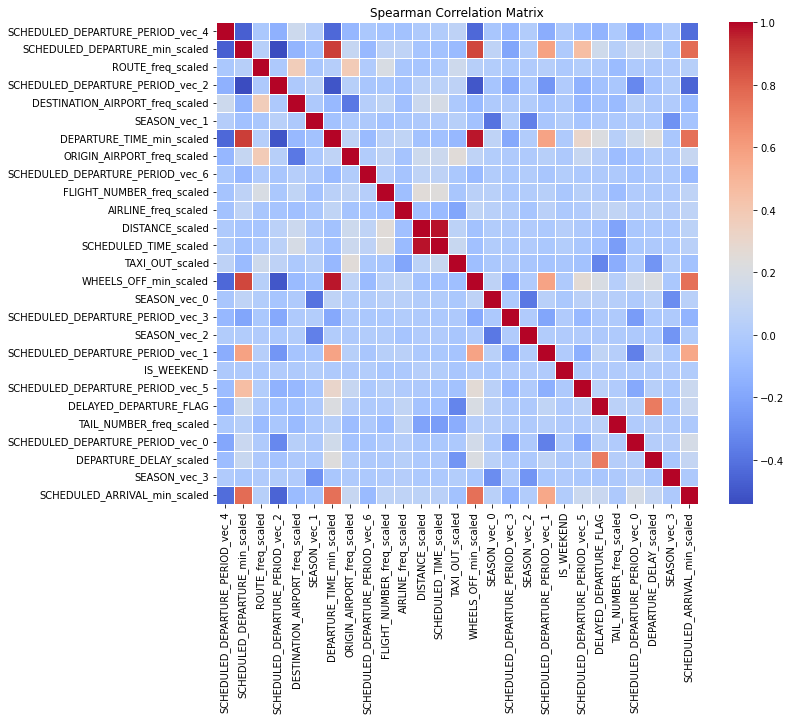

In [0]:
# Assemble feature vector
assembler = VectorAssembler(inputCols=features_to_select, outputCol="features_vec")
train_vector = assembler.transform(final_train_df).select("features_vec")

# Compute Spearman correlation matrix
corr_matrix = Correlation.corr(train_vector, "features_vec", method="spearman").head()[0]
corr_array = corr_matrix.toArray()

# Create DataFrame 
corr_df = pd.DataFrame(corr_array, index=features_to_select, columns=features_to_select)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=False, cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
plt.show()

In [0]:
threshold = 0.80
high_corr_pairs = []

# Convert Spark correlation matrix to nested Python lists
corr_rows = corr_matrix.toArray().tolist()

# Iterate without NumPy
for i in range(len(features_to_select)):
    for j in range(i + 1, len(features_to_select)):
        corr_val = corr_rows[i][j]
        if abs(corr_val) > threshold:
            f1 = features_to_select[i]
            f2 = features_to_select[j]
            high_corr_pairs.append((f1, f2, round(corr_val, 4)))

if high_corr_pairs:
    print(f"\nHighly correlated feature pairs (|correlation| > {threshold}):\n")
    for f1, f2, corr in high_corr_pairs:
        print(f"  {f1:35s} vs {f2:35s} → correlation = {corr}")
else:
    print(f"\nNo feature pairs found with |correlation| > {threshold}.")



Highly correlated feature pairs (|correlation| > 0.8):

  SCHEDULED_DEPARTURE_min_scaled      vs DEPARTURE_TIME_min_scaled           → correlation = 0.9005
  SCHEDULED_DEPARTURE_min_scaled      vs WHEELS_OFF_min_scaled               → correlation = 0.8758
  DEPARTURE_TIME_min_scaled           vs WHEELS_OFF_min_scaled               → correlation = 0.9712
  DISTANCE_scaled                     vs SCHEDULED_TIME_scaled               → correlation = 0.9815


In [0]:
# Index of the target column in the full list (assumed to be last)
target_index = len(features_to_select + target_col) - 2  # target is at the end

# To store decisions and final drops
features_to_drop = set()

print(f"\nHighly correlated pairs (|correlation| > {threshold}) with target correlation comparison:\n")

for f1, f2, corr_val in high_corr_pairs:
    i = features_to_select.index(f1)
    j = features_to_select.index(f2)

    corr_i_target = round(abs(corr_rows[i][target_index]), 4)
    corr_j_target = round(abs(corr_rows[j][target_index]), 4)

    if corr_i_target >= corr_j_target:
        features_to_drop.add(f2)
        decision = f"Dropping '{f2}' (target corr: {corr_j_target})"
    else:
        features_to_drop.add(f1)
        decision = f"Dropping '{f1}' (target corr: {corr_i_target})"

    print(f"{f1} vs {f2}")
    print(f"{f1} = {corr_i_target}, {f2} = {corr_j_target}")
    print(f"{decision}")
    print("-----------------------------")

# Final list of selected features
selected_features = [f for f in features_to_select if f not in features_to_drop]

print(f"\nSelected features after correlation filtering: {len(selected_features)}")


Highly correlated pairs (|correlation| > 0.8) with target correlation comparison:

SCHEDULED_DEPARTURE_min_scaled vs DEPARTURE_TIME_min_scaled
SCHEDULED_DEPARTURE_min_scaled = 0.7696, DEPARTURE_TIME_min_scaled = 0.7557
Dropping 'DEPARTURE_TIME_min_scaled' (target corr: 0.7557)
-----------------------------
SCHEDULED_DEPARTURE_min_scaled vs WHEELS_OFF_min_scaled
SCHEDULED_DEPARTURE_min_scaled = 0.7696, WHEELS_OFF_min_scaled = 0.7573
Dropping 'WHEELS_OFF_min_scaled' (target corr: 0.7573)
-----------------------------
DEPARTURE_TIME_min_scaled vs WHEELS_OFF_min_scaled
DEPARTURE_TIME_min_scaled = 0.7557, WHEELS_OFF_min_scaled = 0.7573
Dropping 'DEPARTURE_TIME_min_scaled' (target corr: 0.7557)
-----------------------------
DISTANCE_scaled vs SCHEDULED_TIME_scaled
DISTANCE_scaled = 0.0552, SCHEDULED_TIME_scaled = 0.0434
Dropping 'SCHEDULED_TIME_scaled' (target corr: 0.0434)
-----------------------------

Selected features after correlation filtering: 24


In [0]:
final_train_df = final_train_df.drop(*features_to_drop)
final_val_df = final_val_df.drop(*features_to_drop)
final_test_df = final_test_df.drop(*features_to_drop)

## 4.7 Feature Selection

In [0]:
clusters = sorted([row['cluster'] for row in final_train_df.select("cluster").distinct().collect()])
print(clusters)

['0', '1', '2', '3', '4', '5']


### 4.7.1 Random Forest per Cluster

In [0]:
rf_importances = defaultdict(dict)

for cl in clusters:
    print(f"\n=== Random Forest Feature Selection for Cluster {cl} ===")

    # Filter to cluster
    cluster_df = final_train_df.filter(col("cluster") == cl)

    # Assemble features
    assembler = VectorAssembler(inputCols=features_to_select, outputCol="features_vec")

    if "features_vec" in cluster_df.columns:
        cluster_df = cluster_df.drop("features_vec")
    
    cluster_vectorized = assembler.transform(cluster_df).select("features_vec", target_col[0])
    cluster_vectorized = cluster_vectorized.withColumnRenamed(target_col[0], "label")

    # Fit Random Forest Regressor
    rf = RandomForestRegressor(featuresCol="features_vec", labelCol="label", numTrees=50, maxDepth=10, seed=42)
    model = rf.fit(cluster_vectorized)

    # Extract and show importances
    importances = model.featureImportances.toArray()
    importance_tuples = sorted(zip(features_to_select, importances), key=lambda x: x[1], reverse=True)

    print(f"Top features:")
    for feat, score in importance_tuples[:10]:
        print(f"  {feat:35s}: {score:.4f}")
    rf_importances[cl][target_col[0]] = importance_tuples


=== Random Forest Feature Selection for Cluster 0 ===
Top features:
  DEPARTURE_DELAY_scaled             : 0.7194
  DELAYED_DEPARTURE_FLAG             : 0.0589
  TAXI_OUT_scaled                    : 0.0330
  SCHEDULED_DEPARTURE_min_scaled     : 0.0282
  ROUTE_freq_scaled                  : 0.0274
  ORIGIN_AIRPORT_freq_scaled         : 0.0242
  SCHEDULED_ARRIVAL_min_scaled       : 0.0200
  TAIL_NUMBER_freq_scaled            : 0.0184
  DESTINATION_AIRPORT_freq_scaled    : 0.0169
  DISTANCE_scaled                    : 0.0164

=== Random Forest Feature Selection for Cluster 1 ===
Top features:
  DEPARTURE_DELAY_scaled             : 0.8588
  DELAYED_DEPARTURE_FLAG             : 0.0297
  TAXI_OUT_scaled                    : 0.0233
  SCHEDULED_DEPARTURE_min_scaled     : 0.0117
  DISTANCE_scaled                    : 0.0116
  ROUTE_freq_scaled                  : 0.0104
  SCHEDULED_ARRIVAL_min_scaled       : 0.0094
  TAIL_NUMBER_freq_scaled            : 0.0087
  ORIGIN_AIRPORT_freq_scaled      

In [0]:
# Extract top 10 features per cluster - (feature, cluster, importance)
all_entries = []
for cl in clusters:
    for feat, imp in rf_importances[cl][target_col[0]][:10]:
        all_entries.append((feat, f"Cluster {cl}", float(round(imp, 4))))

# Create initial Spark DataFrame
schema = StructType([
    StructField("feature", StringType(), True),
    StructField("cluster", StringType(), True),
    StructField("importance", FloatType(), True)
])
raw_df = spark.createDataFrame(all_entries, schema)

# Pivot to (feature rows, clusters as columns)
pivoted_df = raw_df.groupBy("feature").pivot("cluster").agg({"importance": "first"})

# Replace nulls with "-" 
final_df = pivoted_df.fillna("-")

final_df.orderBy("feature").show(truncate=False)

+-------------------------------+---------+---------+---------+---------+---------+---------+
|feature                        |Cluster 0|Cluster 1|Cluster 2|Cluster 3|Cluster 4|Cluster 5|
+-------------------------------+---------+---------+---------+---------+---------+---------+
|AIRLINE_freq_scaled            |null     |null     |null     |null     |null     |0.0181   |
|DELAYED_DEPARTURE_FLAG         |0.0589   |0.0297   |0.0431   |0.0474   |0.0438   |0.0544   |
|DEPARTURE_DELAY_scaled         |0.7194   |0.8588   |0.6743   |0.7592   |0.7665   |0.7684   |
|DESTINATION_AIRPORT_freq_scaled|0.0169   |0.0082   |null     |0.012    |0.0139   |null     |
|DISTANCE_scaled                |0.0164   |0.0116   |0.0305   |null     |0.0198   |0.0138   |
|FLIGHT_NUMBER_freq_scaled      |null     |null     |0.0292   |0.0134   |null     |null     |
|ORIGIN_AIRPORT_freq_scaled     |0.0242   |0.0085   |0.029    |0.0141   |0.0126   |0.0122   |
|ROUTE_freq_scaled              |0.0274   |0.0104   |0.0349 

### 4.7.2 RFE per Cluster

In [0]:
rfe_selected_features = defaultdict(dict)  # {cluster: {target: [features]}}

target_num_features = 10  

for cl in clusters:
    print(f"\n=== RFE for Cluster {cl} ===")

    # Filter to cluster
    cluster_df = final_train_df.filter(col("cluster") == cl)

    # Start with all features
    features = features_to_select.copy()
    excluded_features = []

    while len(features) > target_num_features:
        # Assemble features
        assembler = VectorAssembler(inputCols=features, outputCol="features_vec")

        if "features_vec" in cluster_df.columns:
            cluster_df = cluster_df.drop("features_vec")

        cluster_vectorized = assembler.transform(cluster_df).select("features_vec", target_col[0])
        cluster_vectorized = cluster_vectorized.withColumnRenamed(target_col[0], "label")

        # Fit Random Forest Regressor
        rf = RandomForestRegressor(featuresCol="features_vec", labelCol="label", numTrees=50, maxDepth=10, seed=42)
        model = rf.fit(cluster_vectorized)

        importances = model.featureImportances.toArray()
        feature_importance_dict = dict(zip(features, importances))
        least_important = sorted(feature_importance_dict.items(), key=lambda x: x[1])[0][0]

        print(f"  Removed: {least_important} (importance: {feature_importance_dict[least_important]:.6f})")
        features.remove(least_important)
        excluded_features.append(least_important)

    print(f"Selected features for Cluster {cl}: {features}")
    rfe_selected_features[cl][target_col[0]] = features


=== RFE for Cluster 0 ===
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_2 (importance: 0.000000)
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_3 (importance: 0.000000)
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_1 (importance: 0.000000)
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_0 (importance: 0.000000)
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_5 (importance: 0.000001)
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_6 (importance: 0.000124)
  Removed: SCHEDULED_DEPARTURE_PERIOD_vec_4 (importance: 0.000168)
  Removed: SEASON_vec_0 (importance: 0.001129)
  Removed: SEASON_vec_2 (importance: 0.001415)
  Removed: SEASON_vec_1 (importance: 0.002202)
  Removed: SEASON_vec_3 (importance: 0.002201)
  Removed: IS_WEEKEND (importance: 0.004285)
  Removed: AIRLINE_freq_scaled (importance: 0.013714)
  Removed: TAIL_NUMBER_freq_scaled (importance: 0.012982)
Selected features for Cluster 0: ['SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'DESTINATION_AIRPORT_freq_scaled', 'ORIGIN_AIRPORT_freq_scaled', 'FLIG

In [0]:
from pyspark.sql import Row

all_features = set()

for cl in clusters:
    all_features.update(rfe_selected_features[cl][target_col[0]])


data_rows = []
for feat in sorted(all_features):
    row_dict = {"feature": feat}
    for cl in clusters:
        selected = rfe_selected_features[cl][target_col[0]]
        row_dict[f"Cluster {cl}"] = "✓" if feat in selected else "-"
    data_rows.append(Row(**row_dict))

rfe_df = spark.createDataFrame(data_rows)
rfe_df.orderBy("feature").show(truncate=False)

+-------------------------------+---------+---------+---------+---------+---------+---------+
|feature                        |Cluster 0|Cluster 1|Cluster 2|Cluster 3|Cluster 4|Cluster 5|
+-------------------------------+---------+---------+---------+---------+---------+---------+
|AIRLINE_freq_scaled            |-        |-        |-        |-        |-        |✓        |
|DELAYED_DEPARTURE_FLAG         |✓        |✓        |✓        |✓        |✓        |✓        |
|DEPARTURE_DELAY_scaled         |✓        |✓        |✓        |✓        |✓        |✓        |
|DESTINATION_AIRPORT_freq_scaled|✓        |✓        |-        |✓        |✓        |-        |
|DISTANCE_scaled                |✓        |✓        |✓        |✓        |✓        |✓        |
|FLIGHT_NUMBER_freq_scaled      |✓        |✓        |✓        |✓        |✓        |-        |
|ORIGIN_AIRPORT_freq_scaled     |✓        |✓        |✓        |-        |-        |✓        |
|ROUTE_freq_scaled              |✓        |-        |✓      

### 4.7.3 LASSO per Cluster

In [0]:
lasso_selected_features = defaultdict(dict)  # {cluster: {target: [(feature, coefficient)]}}

# Regularization parameters
elasticNetParam = 1.0  # Lasso
regParam = 0.1

for cl in clusters:
    print(f"\n=== Lasso for Cluster {cl} ===")

    cluster_df = final_train_df.filter(col("cluster") == cl)
    features = features_to_select.copy()

    assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
    if "features_vec" in cluster_df.columns:
        cluster_df = cluster_df.drop("features_vec")

    cluster_vectorized = assembler.transform(cluster_df).select("features_vec", target_col[0])
    cluster_vectorized = cluster_vectorized.withColumnRenamed(target_col[0], "label")

    lasso = LinearRegression(
        featuresCol="features_vec", labelCol="label", 
        elasticNetParam=elasticNetParam, regParam=regParam
    )
    model = lasso.fit(cluster_vectorized)

    coefs = model.coefficients.toArray()
    coef_tuples = list(zip(features, coefs))

    print(f"  Coefficients for Cluster {cl}:")
    for feat, coef in sorted(coef_tuples, key=lambda x: abs(x[1]), reverse=True):
        print(f"    {feat:35s}: {coef:.4f}")

    # Keep only non-zero coefficients
    selected_with_coef = [(feat, coef) for feat, coef in coef_tuples if coef != 0]
    excluded_feats = [feat for feat, coef in coef_tuples if coef == 0]

    print(f"\n  Selected features: {[f for f, _ in selected_with_coef]}")
    print(f"  Excluded features: {excluded_feats}")

    lasso_selected_features[cl][target_col[0]] = selected_with_coef


=== Lasso for Cluster 0 ===
  Coefficients for Cluster 0:
    DEPARTURE_DELAY_scaled             : 67.6748
    SCHEDULED_DEPARTURE_PERIOD_vec_5   : -23.2656
    DELAYED_DEPARTURE_FLAG             : -18.0061
    TAXI_OUT_scaled                    : 9.1494
    SCHEDULED_ARRIVAL_min_scaled       : -2.3553
    SCHEDULED_DEPARTURE_PERIOD_vec_6   : 1.6693
    IS_WEEKEND                         : 1.6467
    SEASON_vec_3                       : -1.1564
    TAIL_NUMBER_freq_scaled            : 1.0141
    DESTINATION_AIRPORT_freq_scaled    : 0.9763
    SEASON_vec_2                       : 0.9511
    AIRLINE_freq_scaled                : -0.8705
    SCHEDULED_DEPARTURE_min_scaled     : -0.5658
    SEASON_vec_1                       : -0.4527
    ORIGIN_AIRPORT_freq_scaled         : -0.1451
    SCHEDULED_DEPARTURE_PERIOD_vec_4   : 0.0000
    ROUTE_freq_scaled                  : 0.0000
    SCHEDULED_DEPARTURE_PERIOD_vec_2   : 0.0000
    FLIGHT_NUMBER_freq_scaled          : 0.0000
    DISTANCE_scale

In [0]:
# (feature, cluster, coefficient)
lasso_rows = []
for cl in clusters:
    for feat, coef in lasso_selected_features[cl][target_col[0]]:
        lasso_rows.append((feat, f"Cluster {cl}", float(round(coef, 4))))

# Define schema
schema = StructType([
    StructField("feature", StringType(), True),
    StructField("cluster", StringType(), True),
    StructField("coefficient", FloatType(), True)
])


lasso_df = spark.createDataFrame(lasso_rows, schema)
pivoted_lasso = lasso_df.groupBy("feature").pivot("cluster").agg({"coefficient": "first"})

# Fill missing values with "-"
final_lasso_df = pivoted_lasso.fillna("0")

final_lasso_df.orderBy("feature").show(truncate=False)


+--------------------------------+---------+---------+---------+---------+---------+---------+
|feature                         |Cluster 0|Cluster 1|Cluster 2|Cluster 3|Cluster 4|Cluster 5|
+--------------------------------+---------+---------+---------+---------+---------+---------+
|AIRLINE_freq_scaled             |-0.8705  |-0.3191  |-0.121   |-5.0345  |-4.014   |-3.7545  |
|DELAYED_DEPARTURE_FLAG          |-18.0061 |-13.0947 |-14.9903 |-13.8791 |-14.9985 |-13.204  |
|DEPARTURE_DELAY_scaled          |67.6748  |66.4718  |66.8685  |66.6796  |67.0726  |67.3222  |
|DESTINATION_AIRPORT_freq_scaled |0.9763   |-0.0848  |0.3493   |0.5047   |0.4981   |2.3118   |
|DISTANCE_scaled                 |null     |-1.3599  |-0.4194  |-1.0712  |-0.4808  |-1.1944  |
|FLIGHT_NUMBER_freq_scaled       |null     |0.1615   |0.4111   |-0.1535  |-0.1784  |-0.4943  |
|IS_WEEKEND                      |1.6467   |null     |null     |0.0308   |0.644    |0.0124   |
|ORIGIN_AIRPORT_freq_scaled      |-0.1451  |-2.214

### 4.7.4 Spearman Correlation per Cluster

In [0]:
features_to_select_target = features_to_select + target_col

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=features_to_select_target, outputCol="features_vec")
train_df_vector = assembler.transform(final_train_df).select("features_vec")

# Compute Spearman correlation
corr_matrix = Correlation.corr(train_df_vector, "features_vec", method="spearman").head()[0]

In [0]:
# Store ranks: cluster → target → {feature: rank}
spearman_ranks = defaultdict(lambda: defaultdict(dict))

# Store raw correlations: cluster → target → {feature: corr}
spearman_corrs = defaultdict(lambda: defaultdict(dict))

for cl in clusters:
    print(f"\n=== Spearman correlation for Cluster {cl} ===")

    # Filter data for the cluster
    cluster_df = final_train_df.filter(col("cluster") == cl)

    # Assemble feature vector
    features_with_target = features_to_select + [target_col[0]]
    assembler = VectorAssembler(inputCols=features_with_target, outputCol="features_vec")
    vector_df = assembler.transform(cluster_df).select("features_vec")

    # Compute correlation matrix
    corr_matrix = Correlation.corr(vector_df, "features_vec", method="spearman").head()[0]
    corr_array = corr_matrix.toArray()

    # Extract correlations with target (last column)
    target_corr_col = [float(row[-1]) for row in corr_array[:-1]]

    # Fill correlation dict (missing ones will be filled as 0 below)
    for feat, corr_val in zip(features_to_select, target_corr_col):
        if corr_val != corr_val:  # check for NaN
            corr_val = 0.0
        spearman_corrs[cl][target_col[0]][feat] = round(corr_val, 4)

    # Now rank features by absolute correlation
    ranked_features = sorted(
        spearman_corrs[cl][target_col[0]].items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )

    for rank, (feat, corr_val) in enumerate(ranked_features, start=1):
        spearman_ranks[cl][target_col[0]][feat] = rank
        print(f"  Cluster {cl} | Rank {rank}: {feat:35s} → corr = {corr_val:.4f}")


=== Spearman correlation for Cluster 0 ===
  Cluster 0 | Rank 1: DEPARTURE_DELAY_scaled              → corr = 0.7543
  Cluster 0 | Rank 2: DELAYED_DEPARTURE_FLAG              → corr = 0.5551
  Cluster 0 | Rank 3: TAXI_OUT_scaled                     → corr = -0.1093
  Cluster 0 | Rank 4: FLIGHT_NUMBER_freq_scaled           → corr = -0.0655
  Cluster 0 | Rank 5: DISTANCE_scaled                     → corr = -0.0619
  Cluster 0 | Rank 6: ORIGIN_AIRPORT_freq_scaled          → corr = -0.0592
  Cluster 0 | Rank 7: SCHEDULED_ARRIVAL_min_scaled        → corr = -0.0437
  Cluster 0 | Rank 8: DESTINATION_AIRPORT_freq_scaled     → corr = 0.0391
  Cluster 0 | Rank 9: ROUTE_freq_scaled                   → corr = -0.0376
  Cluster 0 | Rank 10: SCHEDULED_DEPARTURE_PERIOD_vec_4    → corr = -0.0309
  Cluster 0 | Rank 11: SEASON_vec_2                        → corr = -0.0299
  Cluster 0 | Rank 12: SCHEDULED_DEPARTURE_PERIOD_vec_6    → corr = 0.0261
  Cluster 0 | Rank 13: SEASON_vec_0                      

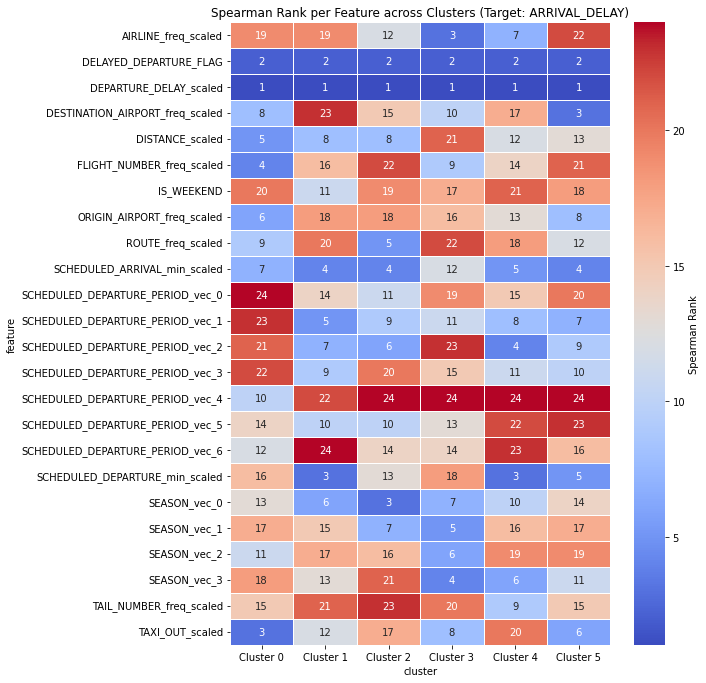

In [0]:

# --- Plot Spearman Ranks ---
plot_data = []

for cl in clusters:
    for feat in features_to_select:
        rank = spearman_ranks[cl][target_col[0]].get(feat, len(features_to_select) + 1)
        plot_data.append((feat, f"Cluster {cl}", rank))

# Create DataFrame for heatmap
rank_df = pd.DataFrame(plot_data, columns=["feature", "cluster", "rank"])
heatmap_rank = rank_df.pivot(index="feature", columns="cluster", values="rank")

# Plot
plt.figure(figsize=(10, len(heatmap_rank) * 0.4))
sns.heatmap(heatmap_rank, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "Spearman Rank"})
plt.title(f"Spearman Rank per Feature across Clusters (Target: {target_col[0]})")
plt.tight_layout()
plt.show()

Note: 
- SEASON_VEC_0 : Winter
- SEASON_VEC_1: Spring
- SEASON_VEC_2: Summer
- SEASON_VEC_3: Fall



 - SCH_DEP_PERIOD_0 : Early Morning (04:00 - 07:59)
 - SCH_DEP_PERIOD_1 : Morning (08:00 - 11:59)
- SCH_DEP_PERIOD_2 : Midday (12:00 - 13:59)
 - SCH_DEP_PERIOD_3 : Afternoon	(14:00 - 17:59)
- SCH_DEP_PERIOD_4 : Evening (18:00 - 20:59)
- SCH_DEP_PERIOD_5 : Night (21:00 - 23:59)
- SCH_DEP_PERIOD_6 : Late Night (00:00 - 03:59)


    


### 4.7.5 Majority Voting

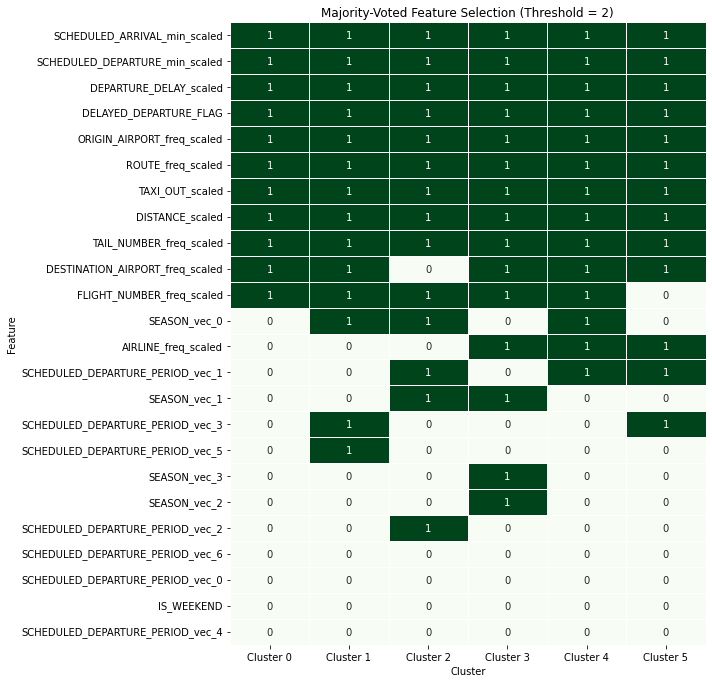

In [0]:
majority_voted_features = defaultdict(dict)
selection_matrix = defaultdict(dict)

topN = 10
majority_threshold = 2

# Aggregate feature selection
for cl in clusters:
    rfe = set(rfe_selected_features[cl][target_col[0]])
    lasso = set([feat for feat, coef in lasso_selected_features[cl][target_col[0]]])
    rf_topN = set([feat for feat, _ in rf_importances[cl][target_col[0]][:topN]])
    spearman_topN = set([feat for feat, rank in spearman_ranks[cl][target_col[0]].items() if rank <= topN])

    # Voting
    methods = [rfe, lasso, rf_topN, spearman_topN]
    all_selected = sum([list(m) for m in methods], [])
    feature_counts = Counter(all_selected)

    # Final features based on threshold
    voted_feats = [feat for feat, count in feature_counts.items() if count >= majority_threshold]
    majority_voted_features[cl][target_col[0]] = voted_feats

    # Fill matrix for visualization
    for feat in set(all_selected):
        selection_matrix[feat][f"Cluster {cl}"] = 1 if feature_counts[feat] >= majority_threshold else 0

# Convert to DataFrame for plotting
selection_df = pd.DataFrame(selection_matrix).T.fillna(0).astype(int)
selection_df["Total"] = selection_df.sum(axis=1)
selection_df = selection_df.sort_values("Total", ascending=False).drop(columns=["Total"])

# Plot heatmap
plt.figure(figsize=(10, 0.4 * len(selection_df)))
sns.heatmap(selection_df, cmap="Greens", cbar=False, linewidths=0.5, annot=True, fmt="d")
plt.title(f"Majority-Voted Feature Selection (Threshold = {majority_threshold})")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 4.8 Models

In [0]:
majority_voted_features

Out[112]: defaultdict(dict,
            {'0': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled',
               'ROUTE_freq_scaled',
               'DEPARTURE_DELAY_scaled',
               'DESTINATION_AIRPORT_freq_scaled',
               'DELAYED_DEPARTURE_FLAG',
               'ORIGIN_AIRPORT_freq_scaled',
               'FLIGHT_NUMBER_freq_scaled',
               'TAXI_OUT_scaled',
               'SCHEDULED_ARRIVAL_min_scaled',
               'DISTANCE_scaled',
               'TAIL_NUMBER_freq_scaled']},
             '1': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled',
               'ORIGIN_AIRPORT_freq_scaled',
               'DEPARTURE_DELAY_scaled',
               'DELAYED_DEPARTURE_FLAG',
               'TAIL_NUMBER_freq_scaled',
               'DESTINATION_AIRPORT_freq_scaled',
               'FLIGHT_NUMBER_freq_scaled',
               'TAXI_OUT_scaled',
               'SCHEDULED_ARRIVAL_min_scaled',
               'DISTANCE_scaled',
               'ROUTE_freq_scaled',


In [0]:
majority_voted_features = defaultdict(dict,
    {'0': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'DEPARTURE_DELAY_scaled',
                             'DESTINATION_AIRPORT_freq_scaled', 'DELAYED_DEPARTURE_FLAG',
                             'ORIGIN_AIRPORT_freq_scaled', 'FLIGHT_NUMBER_freq_scaled', 'TAXI_OUT_scaled',
                             'SCHEDULED_ARRIVAL_min_scaled', 'DISTANCE_scaled', 'TAIL_NUMBER_freq_scaled']},
     '1': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled', 'ORIGIN_AIRPORT_freq_scaled',
                             'DEPARTURE_DELAY_scaled', 'DELAYED_DEPARTURE_FLAG', 'TAIL_NUMBER_freq_scaled',
                             'DESTINATION_AIRPORT_freq_scaled', 'FLIGHT_NUMBER_freq_scaled', 'TAXI_OUT_scaled',
                             'SCHEDULED_ARRIVAL_min_scaled', 'DISTANCE_scaled', 'ROUTE_freq_scaled',
                             'SEASON_vec_0', 'SCHEDULED_DEPARTURE_PERIOD_vec_3', 'SCHEDULED_DEPARTURE_PERIOD_vec_5']},
     '2': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'DEPARTURE_DELAY_scaled',
                             'DELAYED_DEPARTURE_FLAG', 'TAIL_NUMBER_freq_scaled', 'ORIGIN_AIRPORT_freq_scaled',
                             'FLIGHT_NUMBER_freq_scaled', 'TAXI_OUT_scaled', 'SCHEDULED_ARRIVAL_min_scaled',
                             'DISTANCE_scaled', 'SEASON_vec_0', 'SCHEDULED_DEPARTURE_PERIOD_vec_1',
                             'SCHEDULED_DEPARTURE_PERIOD_vec_2', 'SEASON_vec_1']},
     '3': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'DEPARTURE_DELAY_scaled',
                             'DELAYED_DEPARTURE_FLAG', 'TAIL_NUMBER_freq_scaled', 'DESTINATION_AIRPORT_freq_scaled',
                             'FLIGHT_NUMBER_freq_scaled', 'TAXI_OUT_scaled', 'SCHEDULED_ARRIVAL_min_scaled',
                             'DISTANCE_scaled', 'SEASON_vec_1', 'AIRLINE_freq_scaled',
                             'ORIGIN_AIRPORT_freq_scaled', 'SEASON_vec_2', 'SEASON_vec_3']},
     '4': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'DEPARTURE_DELAY_scaled',
                             'DELAYED_DEPARTURE_FLAG', 'TAIL_NUMBER_freq_scaled', 'DESTINATION_AIRPORT_freq_scaled',
                             'FLIGHT_NUMBER_freq_scaled', 'TAXI_OUT_scaled', 'SCHEDULED_ARRIVAL_min_scaled',
                             'DISTANCE_scaled', 'ORIGIN_AIRPORT_freq_scaled', 'SEASON_vec_0',
                             'SCHEDULED_DEPARTURE_PERIOD_vec_1', 'AIRLINE_freq_scaled']},
     '5': {'ARRIVAL_DELAY': ['SCHEDULED_DEPARTURE_min_scaled', 'ROUTE_freq_scaled', 'DEPARTURE_DELAY_scaled',
                             'DELAYED_DEPARTURE_FLAG', 'TAIL_NUMBER_freq_scaled', 'ORIGIN_AIRPORT_freq_scaled',
                             'DISTANCE_scaled', 'TAXI_OUT_scaled', 'SCHEDULED_ARRIVAL_min_scaled',
                             'AIRLINE_freq_scaled', 'SCHEDULED_DEPARTURE_PERIOD_vec_3',
                             'SCHEDULED_DEPARTURE_PERIOD_vec_1', 'DESTINATION_AIRPORT_freq_scaled']}})

In [0]:
def evaluate_regression(predictions, label_col='ARRIVAL_DELAY', metrics=("rmse", "mae", "r2")):
    results = {}
    for metric in metrics:
        evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName=metric)
        results[metric] = evaluator.evaluate(predictions)
    return {k: round(v, 4) for k, v in results.items()}

def get_cast_stages(features):
    stages = []
    for col_name in features:
        stage = SQLTransformer(
            statement=f"SELECT *, CAST({col_name} AS DOUBLE) AS {col_name}_double FROM __THIS__"
        )
        stages.append(stage)
    return stages

def casted_feature_names(features):
    return [f"{f}_double" for f in features]

### 4.8.1 Linear regression

#### Using only DEPARTURE_DELAY

In [0]:
linreg_results = {}
linreg_coeffs = {}

cluster_features = {cl: ['DEPARTURE_DELAY_scaled'] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Linear Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    val_c = final_val_df.filter(col("cluster") == int(cluster))

    # Drop nulls for relevant features + label
    all_required = features + ['ARRIVAL_DELAY']
    train_c = train_c.dropna(subset=all_required)
    val_c = val_c.dropna(subset=all_required)

    # Cast + Assemble
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(inputCols=casted_feature_names(features), outputCol="features")

    # Linear Regression
    linreg = LinearRegression(featuresCol="features", labelCol=target_col[0], maxIter=50)

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, linreg])
    linreg_model = pipeline.fit(train_c)

    # Predictions
    train_pred = linreg_model.transform(train_c)
    val_pred = linreg_model.transform(val_c)

    # Evaluate
    linreg_results[cluster] = {
        "train": evaluate_regression(train_pred),
        "validation": evaluate_regression(val_pred)
    }

    # Extract coefficients
    model_stage = linreg_model.stages[-1]  
    coeffs = model_stage.coefficients.toArray()
    intercept = model_stage.intercept
    linreg_coeffs[cluster] = dict(zip(features, coeffs))
    linreg_coeffs[cluster]['intercept'] = intercept

# Show results
for cl, metrics in linreg_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")

    print("  Coefficients:")
    for feat, coef in linreg_coeffs[cl].items():
        print(f"    {feat:25s}: {coef:.4f}")


Processing Cluster 0 for Linear Regression...

Processing Cluster 1 for Linear Regression...

Processing Cluster 2 for Linear Regression...

Processing Cluster 3 for Linear Regression...

Processing Cluster 4 for Linear Regression...

Processing Cluster 5 for Linear Regression...

=== Cluster 0 ===
  Train: {'rmse': 19.5279, 'mae': 14.8891, 'r2': 0.9547}
  Validation: {'rmse': 21.1085, 'mae': 15.5683, 'r2': 0.9462}
  Coefficients:
    DEPARTURE_DELAY_scaled   : 63.3584
    intercept                : 65.5365

=== Cluster 1 ===
  Train: {'rmse': 13.698, 'mae': 9.665, 'r2': 0.9186}
  Validation: {'rmse': 13.2799, 'mae': 9.4393, 'r2': 0.9116}
  Coefficients:
    DEPARTURE_DELAY_scaled   : 63.0523
    intercept                : 55.2323

=== Cluster 2 ===
  Train: {'rmse': 21.3752, 'mae': 15.3359, 'r2': 0.9105}
  Validation: {'rmse': 18.8556, 'mae': 14.6443, 'r2': 0.9245}
  Coefficients:
    DEPARTURE_DELAY_scaled   : 62.6034
    intercept                : 61.1240

=== Cluster 3 ===
  Train

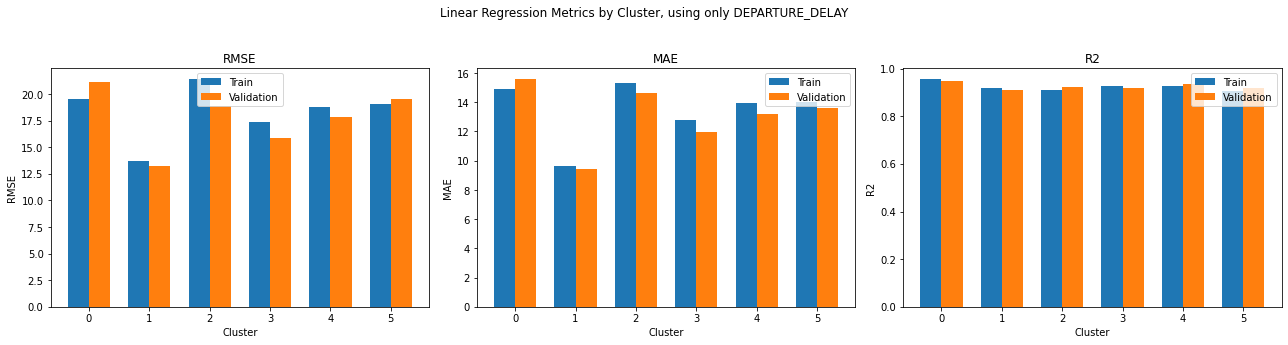

In [0]:
clusters = sorted(linreg_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation']  # Only train and validation

data = {metric: {s: [linreg_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Linear Regression Metrics by Cluster, using only DEPARTURE_DELAY')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Using all selected features

In [0]:
linreg_results = {}
linreg_coeffs = {}

# Extract feature lists per cluster
cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Linear Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    val_c = final_val_df.filter(col("cluster") == int(cluster))

    # Drop nulls for relevant features + label
    all_required = features + ['ARRIVAL_DELAY']
    train_c = train_c.dropna(subset=all_required)
    val_c = val_c.dropna(subset=all_required)

    # Cast + Assemble
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(inputCols=casted_feature_names(features), outputCol="features")

    # Linear Regression
    linreg = LinearRegression(featuresCol="features", labelCol=target_col[0], maxIter=50)

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, linreg])
    linreg_model = pipeline.fit(train_c)

    # Predictions
    train_pred = linreg_model.transform(train_c)
    val_pred = linreg_model.transform(val_c)

    # Evaluate
    linreg_results[cluster] = {
        "train": evaluate_regression(train_pred),
        "validation": evaluate_regression(val_pred)
    }

    # Extract coefficients
    model_stage = linreg_model.stages[-1]  
    coeffs = model_stage.coefficients.toArray()
    intercept = model_stage.intercept
    linreg_coeffs[cluster] = dict(zip(features, coeffs))
    linreg_coeffs[cluster]['intercept'] = intercept

# Show results
for cl, metrics in linreg_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")

    print("  Coefficients:")
    for feat, coef in linreg_coeffs[cl].items():
        print(f"    {feat:25s}: {coef:.4f}")


Processing Cluster 0 for Linear Regression...

Processing Cluster 1 for Linear Regression...

Processing Cluster 2 for Linear Regression...

Processing Cluster 3 for Linear Regression...

Processing Cluster 4 for Linear Regression...

Processing Cluster 5 for Linear Regression...

=== Cluster 0 ===
  Train: {'rmse': 12.8445, 'mae': 9.2651, 'r2': 0.9804}
  Validation: {'rmse': 12.6529, 'mae': 9.1248, 'r2': 0.9807}
  Coefficients:
    SCHEDULED_DEPARTURE_min_scaled: -2.8780
    ROUTE_freq_scaled        : 0.1549
    DEPARTURE_DELAY_scaled   : 67.8003
    DESTINATION_AIRPORT_freq_scaled: 1.0540
    DELAYED_DEPARTURE_FLAG   : -18.4291
    ORIGIN_AIRPORT_freq_scaled: -0.2147
    FLIGHT_NUMBER_freq_scaled: 0.0604
    TAXI_OUT_scaled          : 9.2332
    SCHEDULED_ARRIVAL_min_scaled: -2.1238
    DISTANCE_scaled          : 0.1906
    TAIL_NUMBER_freq_scaled  : 1.1523
    intercept                : 66.0827

=== Cluster 1 ===
  Train: {'rmse': 9.7025, 'mae': 6.7931, 'r2': 0.9592}
  Validation: 

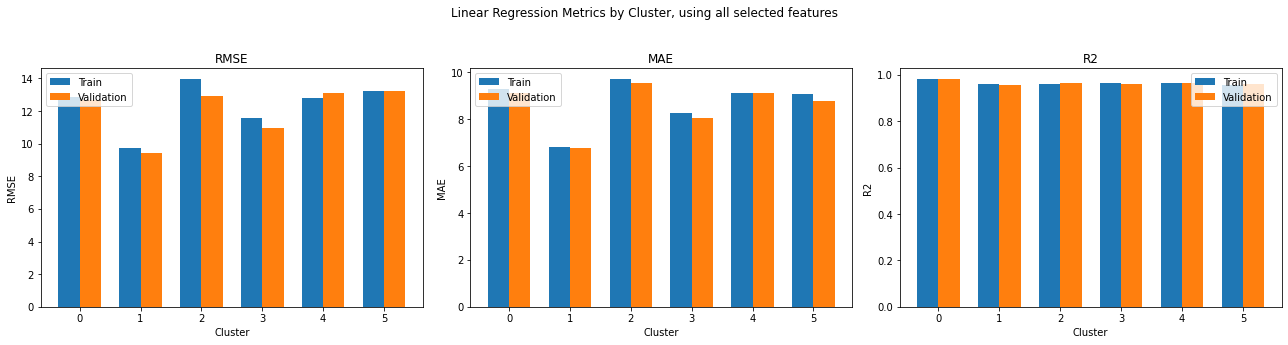

In [0]:
clusters = sorted(linreg_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation']  # Only train and validation

data = {metric: {s: [linreg_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Linear Regression Metrics by Cluster, using all selected features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.8.2 Decision Tree Regression

In [0]:
dtr_results = {}

cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Decision Tree Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    val_c = final_val_df.filter(col("cluster") == int(cluster))

    # Pipeline: cast → assemble → regression
    cast_stages = get_cast_stages(features)

    assembler = VectorAssembler(
        inputCols=casted_feature_names(features),
        outputCol="features"
    )

    dtr = DecisionTreeRegressor(
        featuresCol="features",
        labelCol=target_col[0],  
        maxDepth=5,              
        minInstancesPerNode=10   
    )

    pipeline = Pipeline(stages=cast_stages + [assembler, dtr])

    # Fit model
    dtr_model = pipeline.fit(train_c)

    # Predict
    train_pred = dtr_model.transform(train_c)
    val_pred = dtr_model.transform(val_c)

    # Evaluate
    dtr_results[cluster] = {
        "train": evaluate_regression(train_pred, label_col=target_col[0]),
        "validation": evaluate_regression(val_pred, label_col=target_col[0])
    }

# Show results
for cl, metrics in dtr_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")



Processing Cluster 0 for Decision Tree Regression...

Processing Cluster 1 for Decision Tree Regression...

Processing Cluster 2 for Decision Tree Regression...

Processing Cluster 3 for Decision Tree Regression...

Processing Cluster 4 for Decision Tree Regression...

Processing Cluster 5 for Decision Tree Regression...

=== Cluster 0 ===
  Train: {'rmse': 30.5937, 'mae': 13.2003, 'r2': 0.8888}
  Validation: {'rmse': 50.7745, 'mae': 14.3611, 'r2': 0.6889}

=== Cluster 1 ===
  Train: {'rmse': 13.8871, 'mae': 8.5817, 'r2': 0.9163}
  Validation: {'rmse': 12.8411, 'mae': 8.4154, 'r2': 0.9173}

=== Cluster 2 ===
  Train: {'rmse': 33.9695, 'mae': 13.5214, 'r2': 0.7739}
  Validation: {'rmse': 36.8433, 'mae': 13.6705, 'r2': 0.7119}

=== Cluster 3 ===
  Train: {'rmse': 25.4478, 'mae': 11.3988, 'r2': 0.839}
  Validation: {'rmse': 23.8083, 'mae': 10.9673, 'r2': 0.8186}

=== Cluster 4 ===
  Train: {'rmse': 26.5067, 'mae': 12.243, 'r2': 0.8511}
  Validation: {'rmse': 30.7276, 'mae': 12.7701, 'r2'

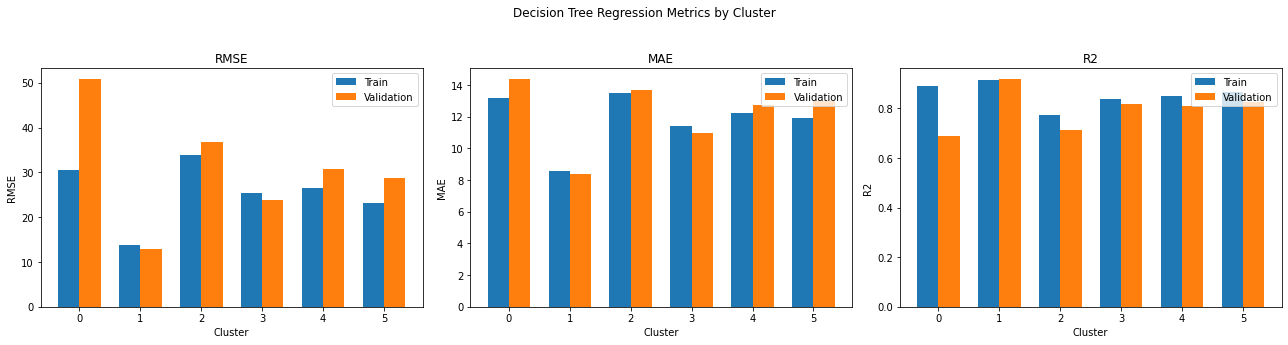

In [0]:
clusters = sorted(dtr_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation']  

data = {metric: {s: [dtr_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Decision Tree Regression Metrics by Cluster')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.8.3 Random Forest

In [0]:
rf_results = {}
rf_importances = {}

cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Random Forest Regression...")

    # Filter data by cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    val_c = final_val_df.filter(col("cluster") == int(cluster))

    # Preprocessing
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(
        inputCols=casted_feature_names(features),
        outputCol="features"
    )

    # Random Forest Regressor
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol=target_col[0],
        numTrees=100,
        maxDepth=7,
        seed=42
    )

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, rf])
    rf_model = pipeline.fit(train_c)

    # Predictions
    train_pred = rf_model.transform(train_c)
    val_pred = rf_model.transform(val_c)

    # Evaluation
    rf_results[cluster] = {
        "train": evaluate_regression(train_pred, label_col=target_col[0]),
        "validation": evaluate_regression(val_pred, label_col=target_col[0])
    }

    # Feature importances
    rf_stage = rf_model.stages[-1]
    importances = rf_stage.featureImportances.toArray()
    rf_importances[cluster] = dict(zip(features, importances))

# Show results
for cl, metrics in rf_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")
    print("  Feature Importances:")
    for feat, imp in sorted(rf_importances[cl].items(), key=lambda x: -x[1]):
        print(f"    {feat:25s}: {imp:.4f}")



Processing Cluster 0 for Random Forest Regression...

Processing Cluster 1 for Random Forest Regression...

Processing Cluster 2 for Random Forest Regression...

Processing Cluster 3 for Random Forest Regression...

Processing Cluster 4 for Random Forest Regression...

Processing Cluster 5 for Random Forest Regression...

=== Cluster 0 ===
  Train: {'rmse': 24.5151, 'mae': 13.1059, 'r2': 0.9286}
  Validation: {'rmse': 48.4298, 'mae': 14.5553, 'r2': 0.7169}
  Feature Importances:
    DEPARTURE_DELAY_scaled   : 0.7485
    DELAYED_DEPARTURE_FLAG   : 0.0708
    TAXI_OUT_scaled          : 0.0353
    ROUTE_freq_scaled        : 0.0264
    ORIGIN_AIRPORT_freq_scaled: 0.0254
    SCHEDULED_DEPARTURE_min_scaled: 0.0181
    DESTINATION_AIRPORT_freq_scaled: 0.0173
    DISTANCE_scaled          : 0.0165
    SCHEDULED_ARRIVAL_min_scaled: 0.0152
    TAIL_NUMBER_freq_scaled  : 0.0133
    FLIGHT_NUMBER_freq_scaled: 0.0131

=== Cluster 1 ===
  Train: {'rmse': 13.5065, 'mae': 9.031, 'r2': 0.9209}
  Valida

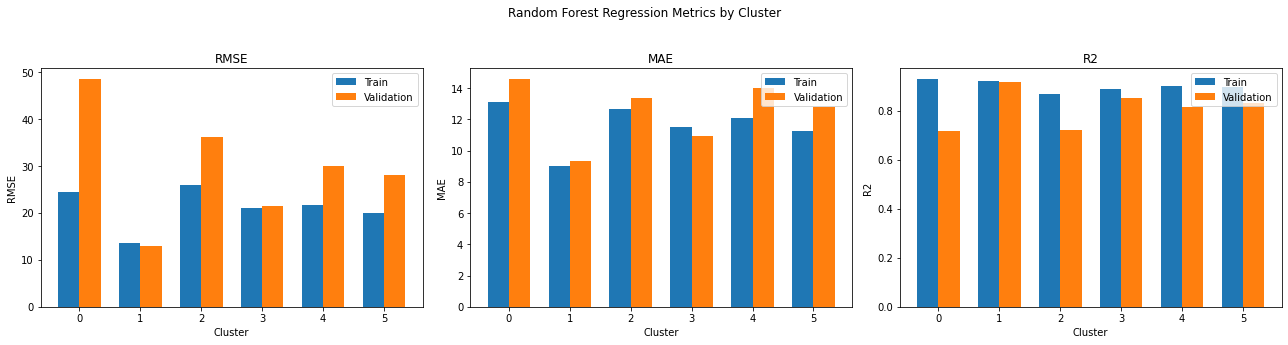

In [0]:
clusters = sorted(rf_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation']

data = {metric: {s: [rf_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Random Forest Regression Metrics by Cluster')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.8.4 Gradient Boosting Tree Regression

In [0]:
gbt_results = {}
gbt_importances = {}

cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Gradient Boosted Tree Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    val_c = final_val_df.filter(col("cluster") == int(cluster))

    # Cast + Assemble
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(
        inputCols=casted_feature_names(features),
        outputCol="features"
    )

    # Gradient Boosted Tree Regressor
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=target_col[0],
        maxIter=50,
        maxDepth=5,
        stepSize=0.1,
        seed=42
    )

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, gbt])
    gbt_model = pipeline.fit(train_c)

    # Predictions
    train_pred = gbt_model.transform(train_c)
    val_pred = gbt_model.transform(val_c)

    # Evaluation
    gbt_results[cluster] = {
        "train": evaluate_regression(train_pred, label_col=target_col[0]),
        "validation": evaluate_regression(val_pred, label_col=target_col[0])
    }

    # Feature importances
    gbt_stage = gbt_model.stages[-1]
    importances = gbt_stage.featureImportances.toArray()
    gbt_importances[cluster] = dict(zip(features, importances))

# Show results
for cl, metrics in gbt_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")
    print("  Feature Importances:")
    for feat, imp in sorted(gbt_importances[cl].items(), key=lambda x: -x[1]):
        print(f"    {feat:25s}: {imp:.4f}")



Processing Cluster 0 for Gradient Boosted Tree Regression...

Processing Cluster 1 for Gradient Boosted Tree Regression...

Processing Cluster 2 for Gradient Boosted Tree Regression...

Processing Cluster 3 for Gradient Boosted Tree Regression...

Processing Cluster 4 for Gradient Boosted Tree Regression...

Processing Cluster 5 for Gradient Boosted Tree Regression...

=== Cluster 0 ===
  Train: {'rmse': 10.4228, 'mae': 7.1868, 'r2': 0.9871}
  Validation: {'rmse': 50.5285, 'mae': 13.7307, 'r2': 0.6919}
  Feature Importances:
    DEPARTURE_DELAY_scaled   : 0.5220
    SCHEDULED_DEPARTURE_min_scaled: 0.0987
    ROUTE_freq_scaled        : 0.0967
    DISTANCE_scaled          : 0.0628
    DESTINATION_AIRPORT_freq_scaled: 0.0439
    SCHEDULED_ARRIVAL_min_scaled: 0.0392
    TAXI_OUT_scaled          : 0.0372
    TAIL_NUMBER_freq_scaled  : 0.0346
    FLIGHT_NUMBER_freq_scaled: 0.0324
    ORIGIN_AIRPORT_freq_scaled: 0.0323
    DELAYED_DEPARTURE_FLAG   : 0.0003

=== Cluster 1 ===
  Train: {'rmse'

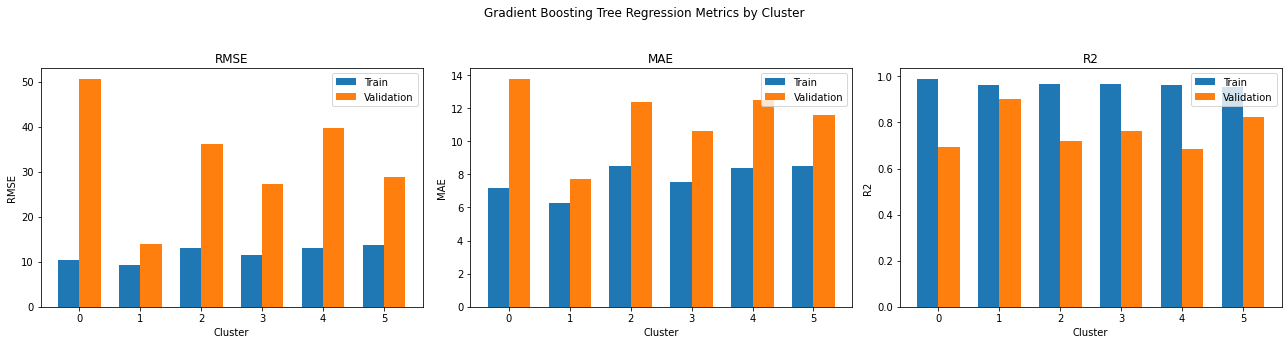

In [0]:
clusters = sorted(gbt_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation']

data = {metric: {s: [gbt_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Gradient Boosting Tree Regression Metrics by Cluster')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4.9 Hyperparameter Tuning

1. Random Forest Regressor


In [0]:
rfreg_results = {}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Random Forest Regression with Hyperparameter Tuning (TrainValidationSplit)...")

    train_c = train_scaled_df.filter(col('cluster') == int(cluster))
    val_c = val_scaled_df.filter(col('cluster') == int(cluster))

    train_c = train_c.na.drop(subset=features)
    val_c = val_c.na.drop(subset=features)

    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(inputCols=casted_feature_names(features), outputCol='features')
    rfreg = RandomForestRegressor(featuresCol='features', labelCol='ARRIVAL_DELAY', seed=42)

    pipeline = Pipeline(stages=cast_stages + [assembler, rfreg])

    paramGrid = (ParamGridBuilder()
        .addGrid(rfreg.numTrees, [50, 100, 200])
        .addGrid(rfreg.maxDepth, [5, 10, 15])
        .addGrid(rfreg.minInstancesPerNode, [1, 2, 4])
        .build())

    evaluator = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="r2")

    # The trainRatio here is for splitting train_c (not for our separate val_c)
    tvs = TrainValidationSplit(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        trainRatio=0.8,  
        parallelism=2
    )

    tvs_model = tvs.fit(train_c)
    best_model = tvs_model.bestModel

    train_pred = best_model.transform(train_c)
    val_pred = best_model.transform(val_c)

    rfreg_results[cluster] = {
        'train': evaluate_regression(train_pred, label_col='ARRIVAL_DELAY'),
        'validation': evaluate_regression(val_pred, label_col='ARRIVAL_DELAY'),
        'best_params': best_model.stages[-1].extractParamMap()
    }

print(rfreg_results)


Processing Cluster 0 for Random Forest Regression with Hyperparameter Tuning (TrainValidationSplit)...

Processing Cluster 1 for Random Forest Regression with Hyperparameter Tuning (TrainValidationSplit)...


In [0]:
clusters = sorted(rfreg_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation']  

data = {metric: {s: [rfreg_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Random Forest Regressor Metrics by Cluster (Tuned)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

2) Gradient Boosting Regressor

In [0]:
gbtreg_results = {}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for GBT Regression with Hyperparameter Tuning (TrainValidationSplit)...")

    train_c = train_scaled_df.filter(col('cluster') == int(cluster))
    val_c = val_scaled_df.filter(col('cluster') == int(cluster))

    train_c = train_c.na.drop(subset=features)
    val_c = val_c.na.drop(subset=features)

    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(inputCols=casted_feature_names(features), outputCol='features')
    gbtreg = GBTRegressor(featuresCol='features', labelCol='ARRIVAL_DELAY', seed=42)

    pipeline = Pipeline(stages=cast_stages + [assembler, gbtreg])

    # Define parameter grid
    paramGrid = (ParamGridBuilder()
        .addGrid(gbtreg.maxIter, [50, 100])
        .addGrid(gbtreg.maxDepth, [3, 5, 8])
        .addGrid(gbtreg.minInstancesPerNode, [1, 2])
        .addGrid(gbtreg.stepSize, [0.05, 0.1, 0.2])
        .build())

    evaluator = RegressionEvaluator(labelCol="ARRIVAL_DELAY", predictionCol="prediction", metricName="r2")

    # Use TrainValidationSplit instead of CrossValidator
    tvs = TrainValidationSplit(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        trainRatio=0.8,      
        parallelism=2
    )

    tvs_model = tvs.fit(train_c)
    best_model = tvs_model.bestModel

    train_pred = best_model.transform(train_c)
    val_pred = best_model.transform(val_c)

    gbtreg_results[cluster] = {
        'train': evaluate_regression(train_pred, label_col='ARRIVAL_DELAY'),
        'validation': evaluate_regression(val_pred, label_col='ARRIVAL_DELAY'),
        'best_params': best_model.stages[-1].extractParamMap()
    }

print(gbtreg_results)


In [0]:
clusters = sorted(gbtreg_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'validation'] 

data = {metric: {s: [gbtreg_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['validation'], width, label='Validation')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('GBT Regressor Metrics by Cluster (Tuned)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4.10 Best Model for each cluster (evaluated on test)

### 4.10.1 Linear regression

#### Using only DEPARTURE_DELAY

In [0]:
linreg_results = {}
linreg_coeffs = {}

cluster_features = {cl: ['DEPARTURE_DELAY_scaled'] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Linear Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    test_c = final_test_df.filter(col("cluster") == int(cluster))

    # Drop nulls for relevant features + label
    all_required = features + ['ARRIVAL_DELAY']
    train_c = train_c.dropna(subset=all_required)
    test_c = test_c.dropna(subset=all_required)

    # Cast + Assemble
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(inputCols=casted_feature_names(features), outputCol="features")

    # Linear Regression
    linreg = LinearRegression(featuresCol="features", labelCol=target_col[0], maxIter=50)

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, linreg])
    linreg_model = pipeline.fit(train_c)

    # Predictions
    train_pred = linreg_model.transform(train_c)
    test_pred = linreg_model.transform(test_c)

    # Evaluate
    linreg_results[cluster] = {
        "train": evaluate_regression(train_pred),
        "test": evaluate_regression(test_pred)
    }

    # Extract coefficients
    model_stage = linreg_model.stages[-1]  
    coeffs = model_stage.coefficients.toArray()
    intercept = model_stage.intercept
    linreg_coeffs[cluster] = dict(zip(features, coeffs))
    linreg_coeffs[cluster]['intercept'] = intercept

# Show results
for cl, metrics in linreg_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")

    print("  Coefficients:")
    for feat, coef in linreg_coeffs[cl].items():
        print(f"    {feat:25s}: {coef:.4f}")


Processing Cluster 0 for Linear Regression...

Processing Cluster 1 for Linear Regression...

Processing Cluster 2 for Linear Regression...

Processing Cluster 3 for Linear Regression...

Processing Cluster 4 for Linear Regression...

Processing Cluster 5 for Linear Regression...

=== Cluster 0 ===
  Train: {'rmse': 19.5279, 'mae': 14.8891, 'r2': 0.9547}
  Test: {'rmse': 19.293, 'mae': 14.7356, 'r2': 0.9596}
  Coefficients:
    DEPARTURE_DELAY_scaled   : 63.3584
    intercept                : 65.5365

=== Cluster 1 ===
  Train: {'rmse': 13.698, 'mae': 9.665, 'r2': 0.9186}
  Test: {'rmse': 12.9831, 'mae': 9.2851, 'r2': 0.9258}
  Coefficients:
    DEPARTURE_DELAY_scaled   : 63.0523
    intercept                : 55.2323

=== Cluster 2 ===
  Train: {'rmse': 21.3752, 'mae': 15.3359, 'r2': 0.9105}
  Test: {'rmse': 21.3197, 'mae': 15.2961, 'r2': 0.8998}
  Coefficients:
    DEPARTURE_DELAY_scaled   : 62.6034
    intercept                : 61.1240

=== Cluster 3 ===
  Train: {'rmse': 17.3435,

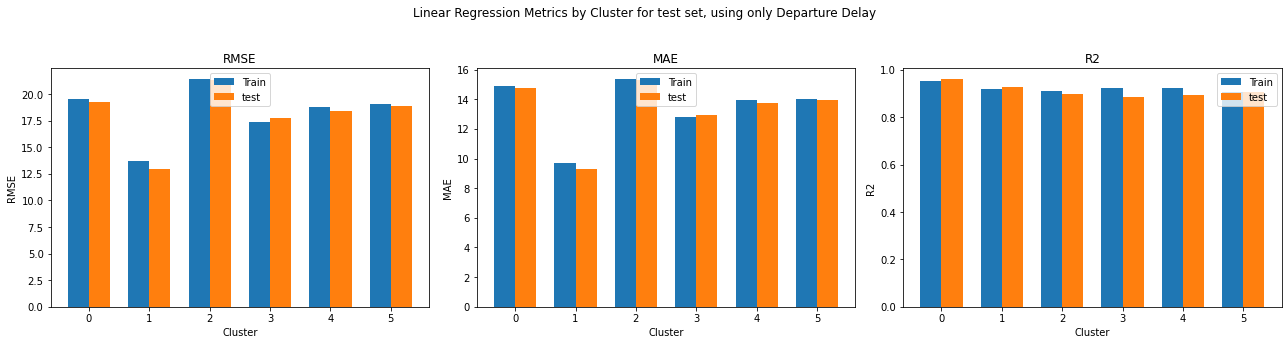

In [0]:
clusters = sorted(linreg_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'test']  # Only train and test

data = {metric: {s: [linreg_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['test'], width, label='test')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Linear Regression Metrics by Cluster for test set, using only Departure Delay')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Using all selected features

In [0]:
linreg_results = {}
linreg_coeffs = {}

# Extract feature lists per cluster
cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Linear Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    test_c = final_val_df.filter(col("cluster") == int(cluster))

    # Drop nulls for relevant features + label
    all_required = features + ['ARRIVAL_DELAY']
    train_c = train_c.dropna(subset=all_required)
    test_c = test_c.dropna(subset=all_required)

    # Cast + Assemble
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(inputCols=casted_feature_names(features), outputCol="features")

    # Linear Regression
    linreg = LinearRegression(featuresCol="features", labelCol=target_col[0], maxIter=50)

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, linreg])
    linreg_model = pipeline.fit(train_c)

    # Predictions
    train_pred = linreg_model.transform(train_c)
    test_pred = linreg_model.transform(test_c)

    # Evaluate
    linreg_results[cluster] = {
        "train": evaluate_regression(train_pred),
        "test": evaluate_regression(test_pred)
    }

    # Extract coefficients
    model_stage = linreg_model.stages[-1]  
    coeffs = model_stage.coefficients.toArray()
    intercept = model_stage.intercept
    linreg_coeffs[cluster] = dict(zip(features, coeffs))
    linreg_coeffs[cluster]['intercept'] = intercept

# Show results
for cl, metrics in linreg_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")

    print("  Coefficients:")
    for feat, coef in linreg_coeffs[cl].items():
        print(f"    {feat:25s}: {coef:.4f}")


Processing Cluster 0 for Linear Regression...

Processing Cluster 1 for Linear Regression...

Processing Cluster 2 for Linear Regression...

Processing Cluster 3 for Linear Regression...

Processing Cluster 4 for Linear Regression...

Processing Cluster 5 for Linear Regression...

=== Cluster 0 ===
  Train: {'rmse': 12.8445, 'mae': 9.2651, 'r2': 0.9804}
  Test: {'rmse': 12.6529, 'mae': 9.1248, 'r2': 0.9807}
  Coefficients:
    SCHEDULED_DEPARTURE_min_scaled: -2.8780
    ROUTE_freq_scaled        : 0.1549
    DEPARTURE_DELAY_scaled   : 67.8003
    DESTINATION_AIRPORT_freq_scaled: 1.0540
    DELAYED_DEPARTURE_FLAG   : -18.4291
    ORIGIN_AIRPORT_freq_scaled: -0.2147
    FLIGHT_NUMBER_freq_scaled: 0.0604
    TAXI_OUT_scaled          : 9.2332
    SCHEDULED_ARRIVAL_min_scaled: -2.1238
    DISTANCE_scaled          : 0.1906
    TAIL_NUMBER_freq_scaled  : 1.1523
    intercept                : 66.0827

=== Cluster 1 ===
  Train: {'rmse': 9.7025, 'mae': 6.7931, 'r2': 0.9592}
  Test: {'rmse': 9.4

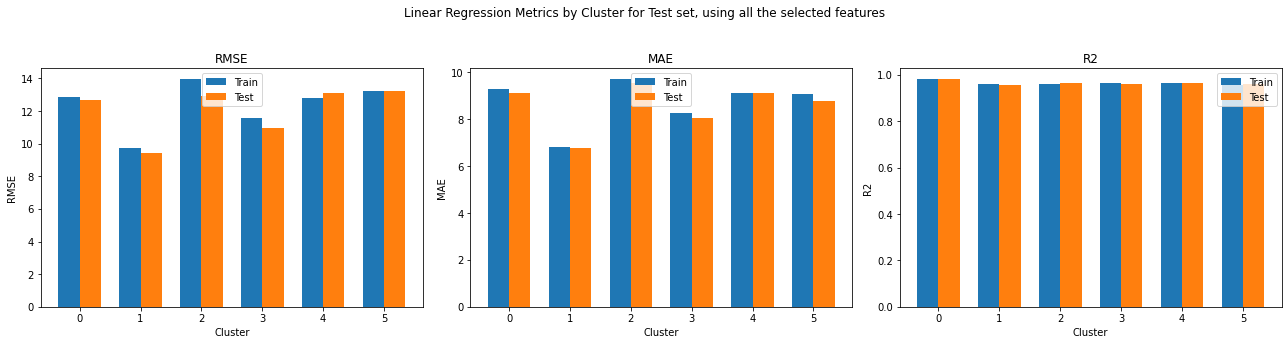

In [0]:
clusters = sorted(linreg_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'test']  # Only train and validation

data = {metric: {s: [linreg_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['test'], width, label='Test')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Linear Regression Metrics by Cluster for Test set, using all the selected features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.10.2 Decision Tree Regression

In [0]:
dtr_results = {}

cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Decision Tree Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    test_c = final_test_df.filter(col("cluster") == int(cluster))

    # Pipeline: cast → assemble → regression
    cast_stages = get_cast_stages(features)

    assembler = VectorAssembler(
        inputCols=casted_feature_names(features),
        outputCol="features"
    )

    dtr = DecisionTreeRegressor(
        featuresCol="features",
        labelCol=target_col[0],  
        maxDepth=5,              
        minInstancesPerNode=10   
    )

    pipeline = Pipeline(stages=cast_stages + [assembler, dtr])

    # Fit model
    dtr_model = pipeline.fit(train_c)

    # Predict
    train_pred = dtr_model.transform(train_c)
    test_pred = dtr_model.transform(test_c)

    # Evaluate
    dtr_results[cluster] = {
        "train": evaluate_regression(train_pred, label_col=target_col[0]),
        "test": evaluate_regression(test_pred, label_col=target_col[0])
    }

# Show results
for cl, metrics in dtr_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")



Processing Cluster 0 for Decision Tree Regression...

Processing Cluster 1 for Decision Tree Regression...

Processing Cluster 2 for Decision Tree Regression...

Processing Cluster 3 for Decision Tree Regression...

Processing Cluster 4 for Decision Tree Regression...

Processing Cluster 5 for Decision Tree Regression...

=== Cluster 0 ===
  Train: {'rmse': 30.5937, 'mae': 13.2003, 'r2': 0.8888}
  Test: {'rmse': 34.5898, 'mae': 13.9725, 'r2': 0.8702}

=== Cluster 1 ===
  Train: {'rmse': 13.8871, 'mae': 8.5817, 'r2': 0.9163}
  Test: {'rmse': 14.6828, 'mae': 8.5556, 'r2': 0.9051}

=== Cluster 2 ===
  Train: {'rmse': 33.9695, 'mae': 13.5214, 'r2': 0.7739}
  Test: {'rmse': 35.9974, 'mae': 13.3637, 'r2': 0.7144}

=== Cluster 3 ===
  Train: {'rmse': 25.4478, 'mae': 11.3988, 'r2': 0.839}
  Test: {'rmse': 19.6527, 'mae': 10.9334, 'r2': 0.8606}

=== Cluster 4 ===
  Train: {'rmse': 26.5067, 'mae': 12.243, 'r2': 0.8511}
  Test: {'rmse': 19.7404, 'mae': 11.4245, 'r2': 0.8776}

=== Cluster 5 ===
 

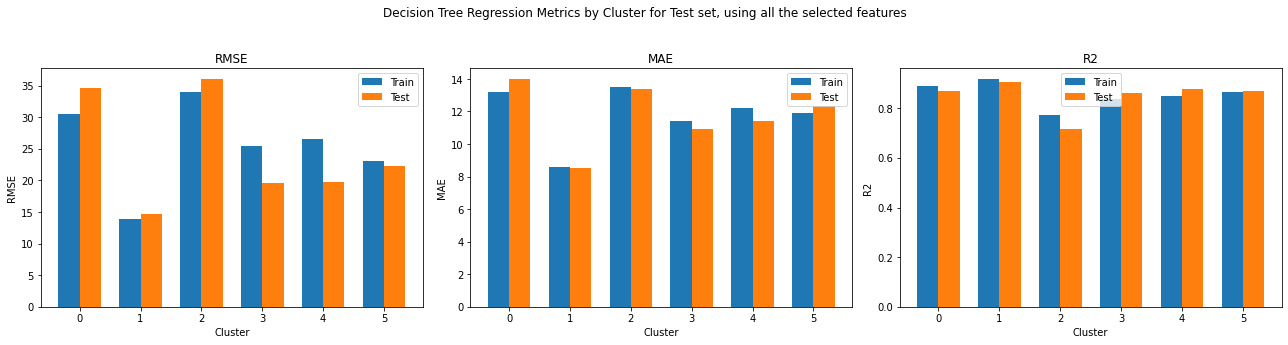

In [0]:
clusters = sorted(dtr_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'test']  

data = {metric: {s: [dtr_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['test'], width, label='Test')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Decision Tree Regression Metrics by Cluster for Test set, using all the selected features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.10.3 Random Forest

In [0]:
rf_results = {}
rf_importances = {}

cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Random Forest Regression...")

    # Filter data by cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    test_c = final_test_df.filter(col("cluster") == int(cluster))

    # Preprocessing
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(
        inputCols=casted_feature_names(features),
        outputCol="features"
    )

    # Random Forest Regressor
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol=target_col[0],
        numTrees=100,
        maxDepth=7,
        seed=42
    )

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, rf])
    rf_model = pipeline.fit(train_c)

    # Predictions
    train_pred = rf_model.transform(train_c)
    test_pred = rf_model.transform(test_c)

    # Evaluation
    rf_results[cluster] = {
        "train": evaluate_regression(train_pred, label_col=target_col[0]),
        "test": evaluate_regression(test_pred, label_col=target_col[0])
    }

    # Feature importances
    rf_stage = rf_model.stages[-1]
    importances = rf_stage.featureImportances.toArray()
    rf_importances[cluster] = dict(zip(features, importances))

# Show results
for cl, metrics in rf_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")
    print("  Feature Importances:")
    for feat, imp in sorted(rf_importances[cl].items(), key=lambda x: -x[1]):
        print(f"    {feat:25s}: {imp:.4f}")



Processing Cluster 0 for Random Forest Regression...

Processing Cluster 1 for Random Forest Regression...

Processing Cluster 2 for Random Forest Regression...

Processing Cluster 3 for Random Forest Regression...

Processing Cluster 4 for Random Forest Regression...

Processing Cluster 5 for Random Forest Regression...

=== Cluster 0 ===
  Train: {'rmse': 24.5151, 'mae': 13.1059, 'r2': 0.9286}
  Test: {'rmse': 40.6074, 'mae': 16.148, 'r2': 0.8212}
  Feature Importances:
    DEPARTURE_DELAY_scaled   : 0.7485
    DELAYED_DEPARTURE_FLAG   : 0.0708
    TAXI_OUT_scaled          : 0.0353
    ROUTE_freq_scaled        : 0.0264
    ORIGIN_AIRPORT_freq_scaled: 0.0254
    SCHEDULED_DEPARTURE_min_scaled: 0.0181
    DESTINATION_AIRPORT_freq_scaled: 0.0173
    DISTANCE_scaled          : 0.0165
    SCHEDULED_ARRIVAL_min_scaled: 0.0152
    TAIL_NUMBER_freq_scaled  : 0.0133
    FLIGHT_NUMBER_freq_scaled: 0.0131

=== Cluster 1 ===
  Train: {'rmse': 13.5065, 'mae': 9.031, 'r2': 0.9209}
  Test: {'rmse'

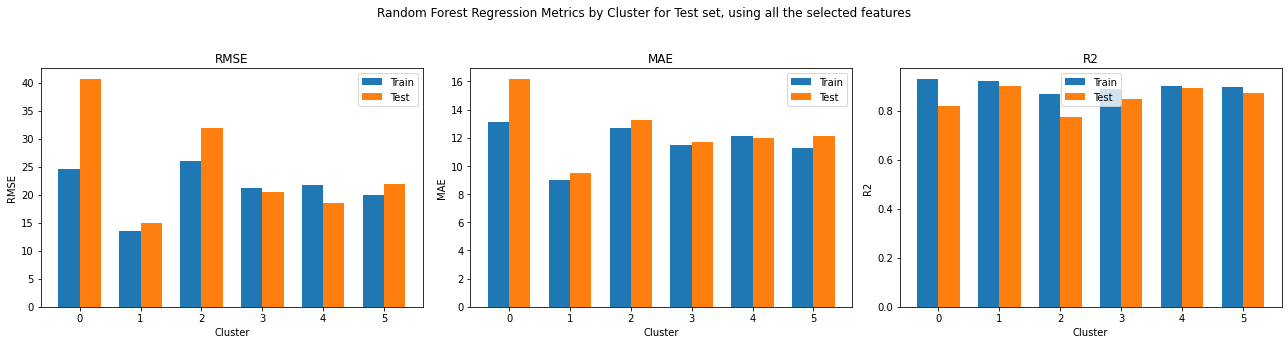

In [0]:
clusters = sorted(rf_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'test']

data = {metric: {s: [rf_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['test'], width, label='Test')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Random Forest Regression Metrics by Cluster for Test set, using all the selected features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.10.4 Gradient Boosting Tree Regression

In [0]:
gbt_results = {}
gbt_importances = {}

cluster_features = {cl: majority_voted_features[cl][target_col[0]] for cl in clusters}

for cluster, features in cluster_features.items():
    print(f"\nProcessing Cluster {cluster} for Gradient Boosted Tree Regression...")

    # Filter data for current cluster
    train_c = final_train_df.filter(col("cluster") == int(cluster))
    test_c = final_test_df.filter(col("cluster") == int(cluster))

    # Cast + Assemble
    cast_stages = get_cast_stages(features)
    assembler = VectorAssembler(
        inputCols=casted_feature_names(features),
        outputCol="features"
    )

    # Gradient Boosted Tree Regressor
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=target_col[0],
        maxIter=50,
        maxDepth=5,
        stepSize=0.1,
        seed=42
    )

    # Pipeline
    pipeline = Pipeline(stages=cast_stages + [assembler, gbt])
    gbt_model = pipeline.fit(train_c)

    # Predictions
    train_pred = gbt_model.transform(train_c)
    test_pred = gbt_model.transform(test_c)

    # Evaluation
    gbt_results[cluster] = {
        "train": evaluate_regression(train_pred, label_col=target_col[0]),
        "test": evaluate_regression(test_pred, label_col=target_col[0])
    }

    # Feature importances
    gbt_stage = gbt_model.stages[-1]
    importances = gbt_stage.featureImportances.toArray()
    gbt_importances[cluster] = dict(zip(features, importances))

# Show results
for cl, metrics in gbt_results.items():
    print(f"\n=== Cluster {cl} ===")
    for split, scores in metrics.items():
        print(f"  {split.capitalize()}: {scores}")
    print("  Feature Importances:")
    for feat, imp in sorted(gbt_importances[cl].items(), key=lambda x: -x[1]):
        print(f"    {feat:25s}: {imp:.4f}")



Processing Cluster 0 for Gradient Boosted Tree Regression...

Processing Cluster 1 for Gradient Boosted Tree Regression...

Processing Cluster 2 for Gradient Boosted Tree Regression...

Processing Cluster 3 for Gradient Boosted Tree Regression...

Processing Cluster 4 for Gradient Boosted Tree Regression...

Processing Cluster 5 for Gradient Boosted Tree Regression...

=== Cluster 0 ===
  Train: {'rmse': 10.4228, 'mae': 7.1868, 'r2': 0.9871}
  Test: {'rmse': 41.1325, 'mae': 13.9317, 'r2': 0.8165}
  Feature Importances:
    DEPARTURE_DELAY_scaled   : 0.5220
    SCHEDULED_DEPARTURE_min_scaled: 0.0987
    ROUTE_freq_scaled        : 0.0967
    DISTANCE_scaled          : 0.0628
    DESTINATION_AIRPORT_freq_scaled: 0.0439
    SCHEDULED_ARRIVAL_min_scaled: 0.0392
    TAXI_OUT_scaled          : 0.0372
    TAIL_NUMBER_freq_scaled  : 0.0346
    FLIGHT_NUMBER_freq_scaled: 0.0324
    ORIGIN_AIRPORT_freq_scaled: 0.0323
    DELAYED_DEPARTURE_FLAG   : 0.0003

=== Cluster 1 ===
  Train: {'rmse': 9.24

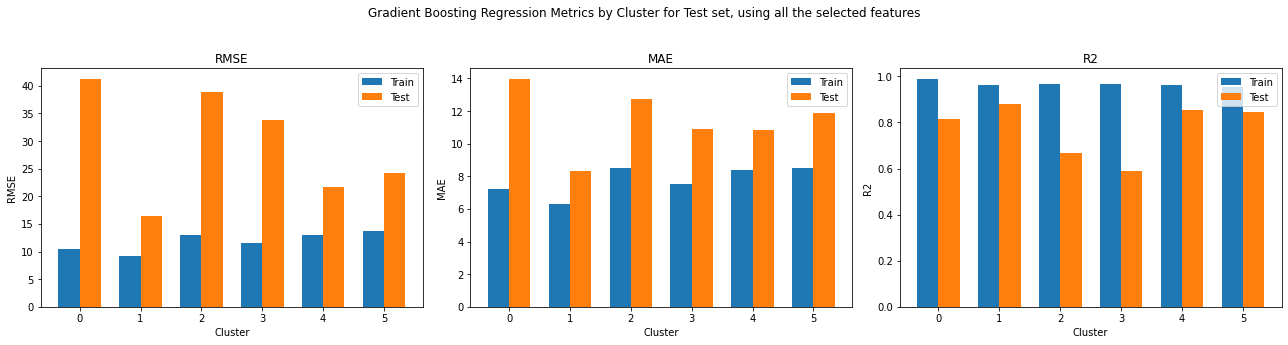

In [0]:
clusters = sorted(gbt_results.keys(), key=int)
metrics = ['rmse', 'mae', 'r2']
sets = ['train', 'test']

data = {metric: {s: [gbt_results[c][s][metric] for c in clusters] for s in sets} for metric in metrics}

x = np.arange(len(clusters))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    ax.bar(x - width/2, data[metric]['train'], width, label='Train')
    ax.bar(x + width/2, data[metric]['test'], width, label='Test')
    ax.set_title(metric.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(clusters)
    ax.legend()
    ax.set_xlabel('Cluster')
    ax.set_ylabel(metric.upper())

fig.suptitle('Gradient Boosting Regression Metrics by Cluster for Test set, using all the selected features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()